In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15, 10)

sys.path.extend([os.getcwd() + "/../", os.getcwd() + "/../../tests/python/", os.getcwd() + "/../../bin/"])
import state_space_model as ssm
#from benchmark_performance import *
import plot_utils

import numpy

In [2]:
dataset_currency = pd.read_csv('daily_csv.csv', sep=',', header=0)
dataset_currency

Date    Country   Value
0       1971-01-04  Australia  0.8987
1       1971-01-05  Australia  0.8983
2       1971-01-06  Australia  0.8977
3       1971-01-07  Australia  0.8978
4       1971-01-08  Australia  0.8990
5       1971-01-11  Australia  0.8967
6       1971-01-12  Australia  0.8964
7       1971-01-13  Australia  0.8957
8       1971-01-14  Australia  0.8937
9       1971-01-15  Australia  0.8943
10      1971-01-18  Australia  0.8945
11      1971-01-19  Australia  0.8934
12      1971-01-20  Australia  0.8934
13      1971-01-21  Australia  0.8930
14      1971-01-22  Australia  0.8925
15      1971-01-25  Australia  0.8909
16      1971-01-26  Australia  0.8905
17      1971-01-27  Australia  0.8905
18      1971-01-28  Australia  0.8902
19      1971-01-29  Australia  0.8900
20      1971-02-01  Australia  0.8896
21      1971-02-02  Australia  0.8897
22      1971-02-03  Australia  0.8896
23      1971-02-04  Australia  0.8902
24      1971-02-05  Australia  0.8909
25      1971-02-08  Australia  0.8897
26      1971-02-09  Australia  0.8908
27      1971-02-10  Australia  0.8906
28      1971-02-11  Australia  0.8906
29      1971-02-12  Australia     NaN
...            ...        ...     ...
226503  2017-10-23  Venezuela  9.9750
226504  2017-10-24  Venezuela  9.9750
226505  2017-10-25  Venezuela  9.9750
226506  2017-10-26  Venezuela  9.9750
226507  2017-10-27  Venezuela  9.9750
226508  2017-10-30  Venezuela  9.9750
226509  2017-10-31  Venezuela  9.9750
226510  2017-11-01  Venezuela  9.9750
226511  2017-11-02  Venezuela  9.9750
226512  2017-11-03  Venezuela  9.9750
226513  2017-11-06  Venezuela  9.9750
226514  2017-11-07  Venezuela  9.9750
226515  2017-11-08  Venezuela  9.9750
226516  2017-11-09  Venezuela  9.9750
226517  2017-11-10  Venezuela     NaN
226518  2017-11-13  Venezuela  9.9750
226519  2017-11-14  Venezuela  9.9750
226520  2017-11-15  Venezuela  9.9750
226521  2017-11-16  Venezuela  9.9750
226522  2017-11-17  Venezuela  9.9750
226523  2017-11-20  Venezuela  9.9750
226524  2017-11-21  Venezuela  9.9750
226525  2017-11-22  Venezuela  9.9750
226526  2017-11-23  Venezuela     NaN
226527  2017-11-24  Venezuela  9.9750
226528  2017-11-27  Venezuela  9.9750
226529  2017-11-28  Venezuela  9.9750
226530  2017-11-29  Venezuela  9.9750
226531  2017-11-30  Venezuela  9.9750
226532  2017-12-01  Venezuela  9.9750

[226533 rows x 3 columns]

In [3]:
#countries = ["United Kingdom", "Venezuela", "India", "Brazil", "Euro", "Norway"]
countries = ["United Kingdom", "India", "Brazil", "Euro", "Norway"]
dates = dataset_currency["Date"].unique()
data_countries = {}
dates_countries = {}
for country in countries:
    country_data = dataset_currency[dataset_currency["Country"] == country]
    #country_data = country_data[country_data["Date"] in valid_dates]
    data_countries[country] = country_data
    dates_countries[country] = country_data["Date"].unique()
    print(country, country_data.shape)

valid_dates = np.array([
    date for date in dates
    if all(
        date in dates_countries[country]
        for country in countries
    )
])
print(valid_dates)

United Kingdom (12240, 3)
India (11719, 3)
Brazil (5980, 3)
Euro (4935, 3)
Norway (12240, 3)
['1999-01-04' '1999-01-05' '1999-01-06' ... '2017-11-29' '2017-11-30'
 '2017-12-01']


In [4]:
country_dates = None
country_rates = np.zeros((len(countries), len(valid_dates)), dtype="f")
for k, country in enumerate(countries):
    country_data = dataset_currency[dataset_currency["Country"] == country]
    country_data = country_data[country_data["Date"].isin(valid_dates)]
    country_dates = np.array(country_data.loc[:, "Date"], dtype=str)
    df = np.array(country_data.loc[:, "Value"]).astype("f")
    # Replace NaNs
    for _ in range(10):
        indices = np.where(np.isnan(df[:]))[0]
        if len(indices) == 0:
            print("No NaN!")
            break
        if len(indices) == 2 and indices[1] == indices[0] + 1:
            df[indices[0]] = df[indices[0] - 1] + (df[indices[1] + 2] - df[indices[0] - 1]) / 3
            df[indices[1]] = df[indices[0] - 1] + 2 * (df[indices[1] + 2] - df[indices[0] - 1]) / 3
        else:
            df[indices] = 0.5 * (df[indices + 1] + df[indices - 1])
    
    #
    country_rates[k, :] = df
    data_countries[country] = df
    print(country, data_countries[country].shape)

No NaN!
United Kingdom (4935,)
No NaN!
India (4935,)
No NaN!
Brazil (4935,)
No NaN!
Euro (4935,)
No NaN!
Norway (4935,)


(5, 4935)


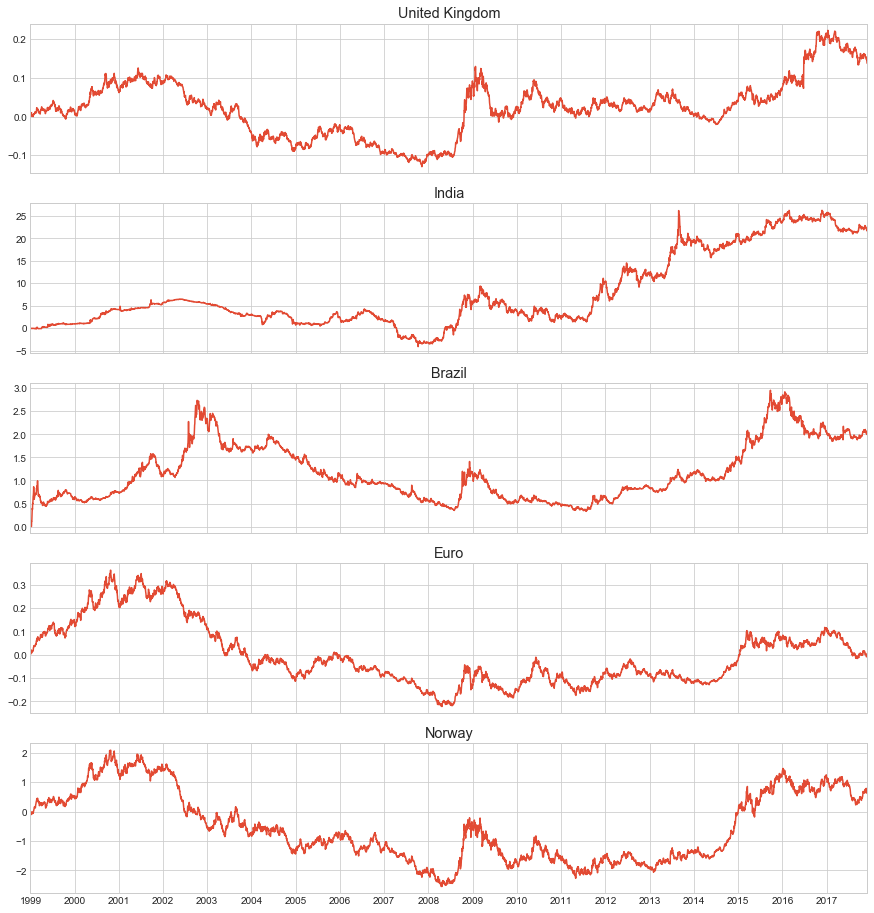

In [5]:
Yx1 = country_rates
Yx1 = (Yx1.T - Yx1[:, 0]).T
print(Yx1.shape)
#
idxnames = []
names = []
for i in np.arange(len(valid_dates)):
    name = "-".join(valid_dates[i].split("-")[:1])
    if name not in names:
        names.append(name)
        idxnames.append(i)
empty_names = [""] * len(names)
#
plt.figure(figsize=(15, 16))
for k, country in enumerate(countries):
    plt.subplot(len(countries), 1, k + 1)
    plt.plot(Yx1[k, :].ravel())
    plt.title(country)
    plt.xticks(idxnames, empty_names)
    plt.xlim(0, len(valid_dates))
plt.xticks(idxnames, names)
None

In [6]:
def plot_fitted_data(countries, Xs, Ys, Y=None, dates=None):
    nrows = max(Xs.shape[0], Ys.shape[0])
    plt.figure(figsize=(15, 5 * nrows))
    for k in range(Xs.shape[0]):
        plt.subplot(nrows, 2, 2 * k + 2)
        plt.plot(Xs[k, :].ravel(), linestyle="-.", color="black", alpha=0.5, label="Exchange rate interaction")
        plt.title("Exchange rate interaction (dim. {0})".format(k + 1))
        if dates is not None:
            plt.xticks(*dates)
        plt.xlim(0, Xs.shape[1])
        plt.legend()
    for k in range(Ys.shape[0]):
        plt.subplot(nrows, 2, 2 * k + 1)
        plt.plot(Ys[k, :].ravel(), linestyle="-", color="coral", label="Estimated exchange rate")
        plt.plot(Y[k, :].ravel(), linestyle="-.", color="black", alpha=0.5, label="Normalized exchange rate")
        plt.title("Normalized currency exchange rate - {0}".format(countries[k]))
        if dates is not None:
            plt.xticks(*dates)
        plt.xlim(0, Ys.shape[1])
        plt.legend()
    plt.tight_layout()
    #plt.show()

def ticks_from_first_week_day(valid_dates):
    # Very inefficient, but it was made in 3 minutes. Do not ask me sth excellent XD
    idxnames = []
    names = []
    vnames = []
    for i in np.arange(len(valid_dates)):
        parts = valid_dates[i].split("-")
        month = int(parts[1])
        day = int(parts[2])
        if len(vnames) == 0 and day > 20:
            month += 1
            day = 1
        day = min(1, day // 15)
        vname = "{0}-{1}".format(month, day)
        parts = parts[1:]
        name = "/".join(parts)
        if vname not in vnames:
            vnames.append(vname)
            names.append(name)
            idxnames.append(i)
    #empty_names = [""] * len(names)
    return idxnames, names
#print(Y_dates)

In [7]:

class resdict:
    Xp = None
    Pp = None
    Yp = None
    Xf = None
    Pf = None
    Yf = None
    Xs = None
    Ps = None
    Ys = None
    LL = None
    F = None
    H = None
    Q = None
    R = None
    X0 = None
    P0 = None
    obs_dim = None
    lat_dim = None
    
    def show_performance(self, Y):
        performance = lambda params, Y, lat_dim: print("\n".join("* {0}: {1:.2g}".format(b, np.round(a, 2)) for a, b in zip(ssm.performance_of_parameters(Y, Y.shape[0], lat_dim, Y.shape[1], params.F, params.H, params.Q, params.R, params.X0, params.P0), ("Log-likelihood", "Low variance Q", "Low variance R", "Low variance P0", "Low std/mean ratio", "Inestable system", "MSE", "Roughness X", "Roughness Y"))))
        return performance(self, Y, self.lat_dim)
    
    def copy(self):
        other = resdict()
        other.Xp = self.Xp
        other.Pp = self.Pp
        other.Yp = self.Yp
        other.Xf = self.Xf
        other.Pf = self.Pf
        other.Yf = self.Yf
        other.Xs = self.Xs
        other.Ps = self.Ps
        other.Ys = self.Ys
        other.LL = self.LL
        other.F = self.F
        other.H = self.H
        other.Q = self.Q
        other.R = self.R
        other.X0 = self.X0
        other.P0 = self.P0
        other.obs_dim = self.obs_dim
        other.lat_dim = self.lat_dim
        return other
        


def resdict_fromdata(V):
    obj = resdict()
    obj.F = V[0]
    obj.H = V[1]
    obj.Q = V[2]
    obj.R = V[3]
    obj.X0 = V[4]
    obj.P0 = V[5]
    obj.obs_dim = obj.H.shape[0]
    obj.lat_dim = obj.P0.shape[0]
    #
    obj.Xp = V[6]
    obj.Pp = V[7]
    obj.Yp = V[8]
    obj.Xf = V[9]
    obj.Pf = V[10]
    obj.Yf = V[11]
    obj.Xs = V[12]
    obj.Ps = V[13]
    obj.Ys = V[14]
    obj.LL = V[15]
    #
    return obj


In [8]:
#Y.mean(axis=1).shape, Y.shape


* Log-likelihood: 0
* Low variance Q: 10
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0.01
* Inestable system: 0.42
* MSE: 0.4
* Roughness X: 0.75
* Roughness Y: 9.6

* Log-likelihood: 0
* Low variance Q: 7.5
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0.01
* Inestable system: 0.42
* MSE: 0.4
* Roughness X: 0.7
* Roughness Y: 9

* Log-likelihood: -4.8
* Low variance Q: 1.1e+03
* Low variance R: 0.05
* Low variance P0: 0
* Low std/mean ratio: 0
* Inestable system: 0.62
* MSE: 0.53
* Roughness X: 32
* Roughness Y: 1.7e+03

* Log-likelihood: -4.2
* Low variance Q: 1.9e+02
* Low variance R: 0.86
* Low variance P0: 0
* Low std/mean ratio: 1
* Inestable system: 33
* MSE: 0.4
* Roughness X: 0.63
* Roughness Y: 8.1


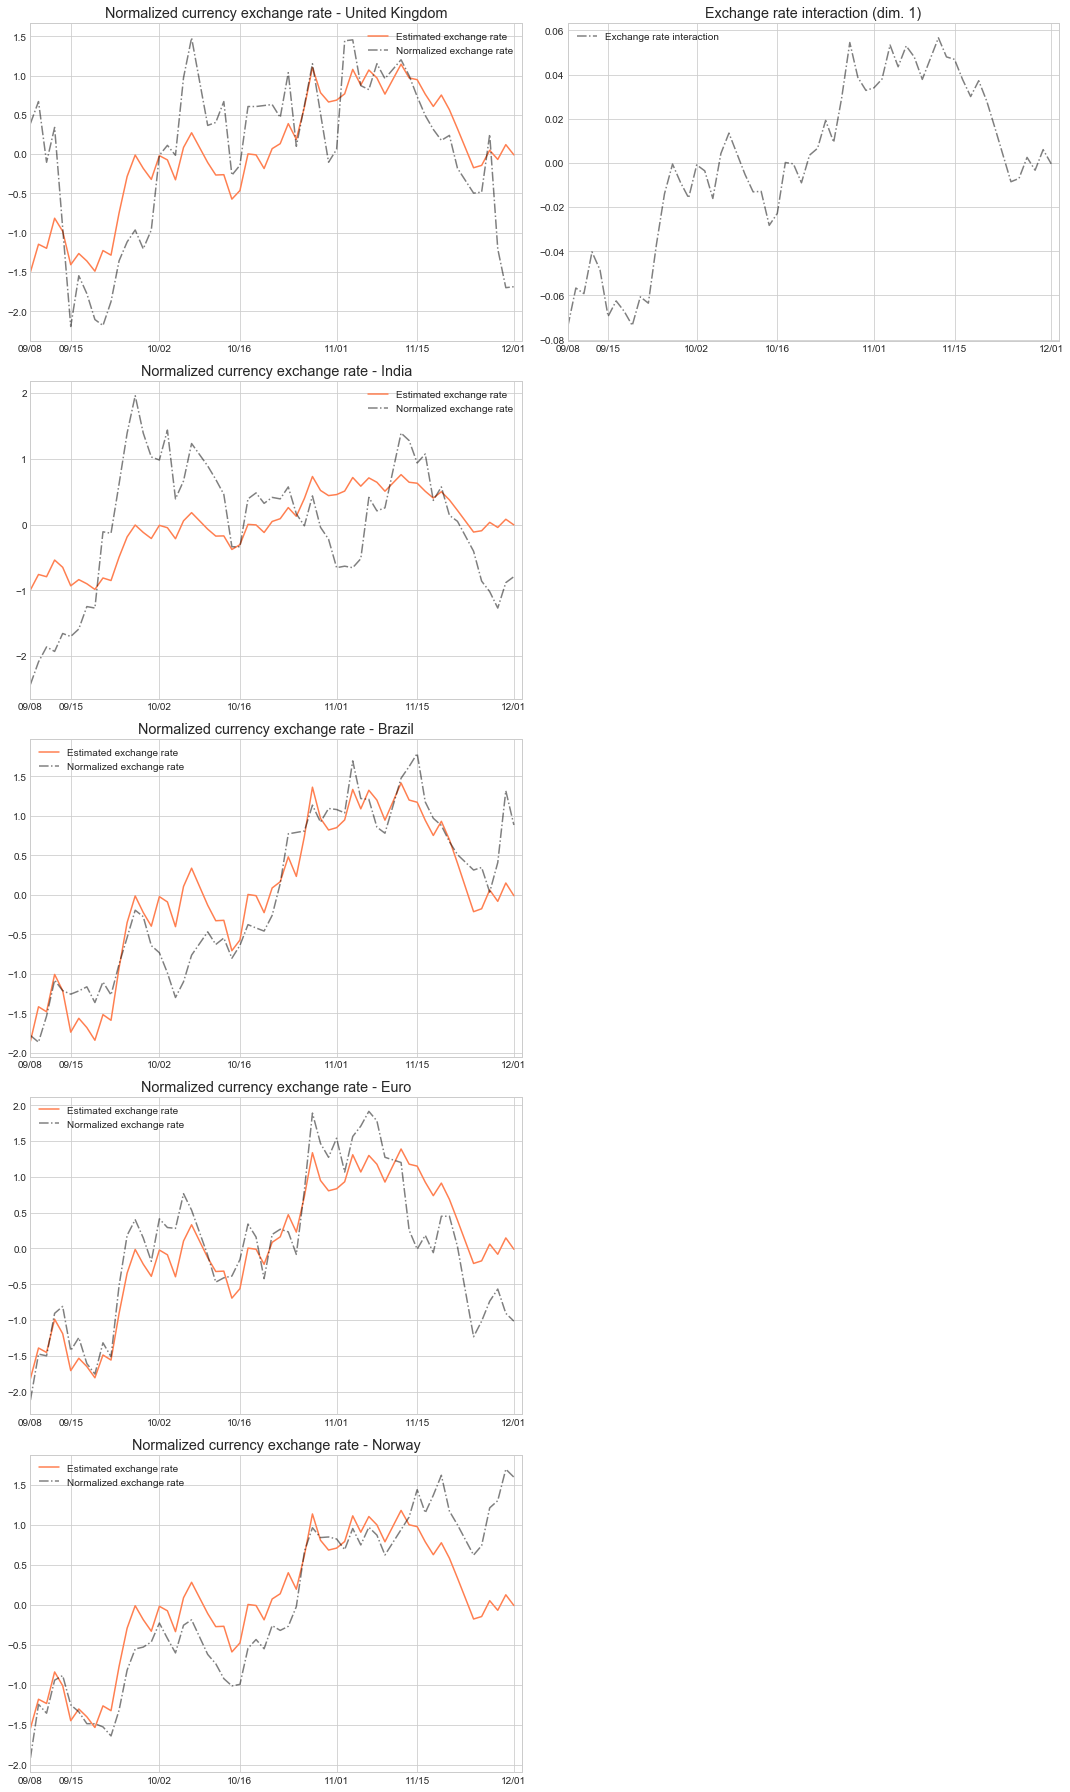

In [9]:
Y = country_rates.astype("f8")
Y = Y[:, -61:]
Y_dates = valid_dates[-61: ]
#Y = (Y.T - Y[:, 0]).T
Y = ((Y.T - Y.mean(axis=1)) / Y.std(axis=1)).T
#Y = Y[:, -30:]

lat_dim = 1
estimation_params = dict(
        min_iterations=3,
        max_iterations=50,

        min_improvement=0.01,
        sample_size=10000,
        population_size=100,
        penalty_low_variance_Q=0,#0.5,
        penalty_low_variance_R=0,#0.5,
        penalty_low_variance_P0=0,#0.5,
        penalty_low_std_mean_ratio=0,#0.5,
        penalty_inestable_system=0,#10.0,
        penalty_mse=1e9,#100,#1e-1,
        penalty_roughness_X=0,#0.5,
        penalty_roughness_Y=0,#0.5,
        max_length_loglikelihood=1000,
        return_details=True,
        random_spread=10,
)
method = "PSO"
params1 = resdict_fromdata(ssm.estimate(
        method, "F H", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=None, H=None, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params1.show_performance(Y)
params2 = resdict_fromdata(ssm.estimate(
        method, "X0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params1.F, H=params1.H, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params2.show_performance(Y)
params3 = resdict_fromdata(ssm.estimate(
        method, "Q R P0", Y,
        Y.shape[0], 6, Y.shape[1],
        F=params2.F, H=params2.F, 
        Q=params2.Q, R=params2.R, 
        X0=None, P0=None,
        **estimation_params
))
print(); params3.show_performance(Y)
params4 = resdict_fromdata(ssm.estimate(
        method, "H F Q R X0 P0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params3.F, H=params3.F, 
        Q=params3.Q, R=params3.R, 
        X0=params3.X0, P0=params3.P0,
        **estimation_params
))
print(); params4.show_performance(Y)
plot_fitted_data(countries, params4.Xs, params4.Ys, Y, dates=ticks_from_first_week_day(Y_dates))

In [10]:
Y_dates[29]
#https://www.dailymail.co.uk/home/sitemaparchive/day_20171019.html
#The Latest: Merkel says May's Brexit effort still not enough
#https://www.dailymail.co.uk/home/sitemaparchive/day_20171018.html
#US STOCKS-Dow ends above 23,000 for first time; IBM jumps

'2017-10-19'

4498 : 4618 (5, 4935) (4935,)

* Log-likelihood: 0
* Low variance Q: 10
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0.01
* Inestable system: 0
* MSE: 0.36
* Roughness X: 0.78
* Roughness Y: 71

* Log-likelihood: 0
* Low variance Q: 1.4e+02
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0.01
* Inestable system: 0
* MSE: 0.36
* Roughness X: 0.77
* Roughness Y: 71

* Log-likelihood: 0
* Low variance Q: 2.7e+02
* Low variance R: 0
* Low variance P0: 0
* Low std/mean ratio: 0
* Inestable system: 0.01
* MSE: 0.69
* Roughness X: 0.05
* Roughness Y: 8.3

* Log-likelihood: 0
* Low variance Q: 30
* Low variance R: 0.99
* Low variance P0: 0
* Low std/mean ratio: 0.29
* Inestable system: 0.08
* MSE: 0.39
* Roughness X: 0.47
* Roughness Y: 50


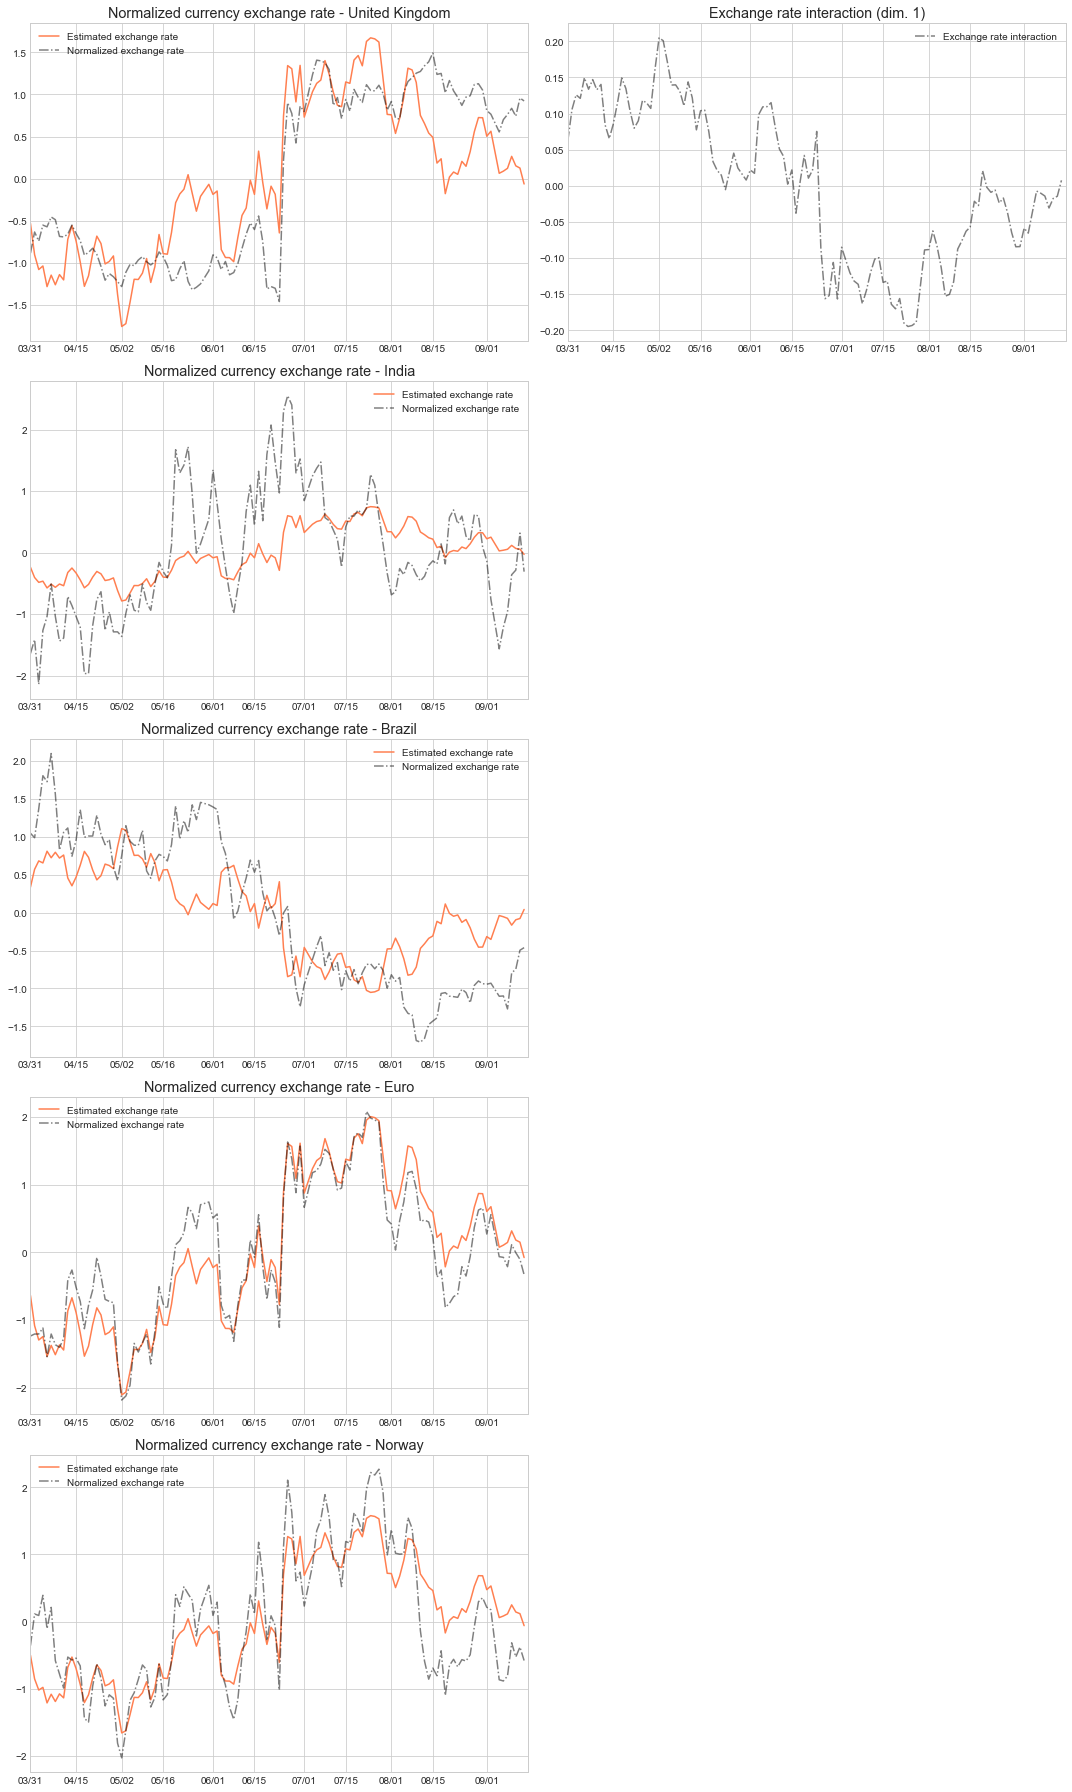

In [13]:
trump_election_day = '2016-06-23'#'2016-09-08'
index_trump_election_day = np.where(valid_dates == trump_election_day)[0][0]
days_before, days_after = 60, 60
Y = country_rates.astype("f8")
print(index_trump_election_day - days_before, ":", index_trump_election_day + days_after, Y.shape, valid_dates.shape)
# Y = country_rates.astype("f8")
Y = Y[:, index_trump_election_day - days_before: index_trump_election_day + days_after]
Y_dates = valid_dates[index_trump_election_day - days_before: index_trump_election_day + days_after]
#Y = (Y.T - Y[:, 0]).T
Y = ((Y.T - Y.mean(axis=1)) / Y.std(axis=1)).T
#Y = Y[:, -30:]

lat_dim = 1
estimation_params = dict(
        min_iterations=3,
        max_iterations=50,

        min_improvement=0.01,
        sample_size=10000,
        population_size=100,
        penalty_low_variance_Q=0,#0.5,
        penalty_low_variance_R=0,#0.5,
        penalty_low_variance_P0=0,#0.5,
        penalty_low_std_mean_ratio=0,#0.5,
        penalty_inestable_system=0,#10.0,
        penalty_mse=1e15,#100,#1e-1,
        penalty_roughness_X=0,#0.5,
        penalty_roughness_Y=0,#0.5,
        max_length_loglikelihood=1000,
        return_details=True,
        random_spread=10,
)
method = "PSO"
params1 = resdict_fromdata(ssm.estimate(
        method, "F H", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=None, H=None, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params1.show_performance(Y)
params2 = resdict_fromdata(ssm.estimate(
        method, "X0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params1.F, H=params1.H, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params2.show_performance(Y)
params3 = resdict_fromdata(ssm.estimate(
        method, "Q R P0", Y,
        Y.shape[0], 6, Y.shape[1],
        F=params2.F, H=params2.F, 
        Q=params2.Q, R=params2.R, 
        X0=None, P0=None,
        **estimation_params
))
print(); params3.show_performance(Y)
params4 = resdict_fromdata(ssm.estimate(
        method, "H F Q R X0 P0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params3.F, H=params3.F, 
        Q=params3.Q, R=params3.R, 
        X0=params3.X0, P0=params3.P0,
        **estimation_params
))
print(); params4.show_performance(Y)
plot_fitted_data(countries, params4.Xs, params4.Ys, Y, dates=ticks_from_first_week_day(Y_dates))

4498 : 4618 (5, 4935) (4935,)

* Log-likelihood: 0
* Low variance Q: 10
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0.01
* Inestable system: 21
* MSE: 0.37
* Roughness X: 0.71
* Roughness Y: 65

* Log-likelihood: 0
* Low variance Q: 18
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0.01
* Inestable system: 21
* MSE: 0.37
* Roughness X: 0.71
* Roughness Y: 64

* Log-likelihood: 0
* Low variance Q: 98
* Low variance R: 0
* Low variance P0: 0
* Low std/mean ratio: 0
* Inestable system: 28
* MSE: 0.37
* Roughness X: 4.8
* Roughness Y: 1.1e+03

* Log-likelihood: 0
* Low variance Q: 15
* Low variance R: 0.07
* Low variance P0: 0.02
* Low std/mean ratio: 0.23
* Inestable system: 11
* MSE: 0.36
* Roughness X: 0.7
* Roughness Y: 64


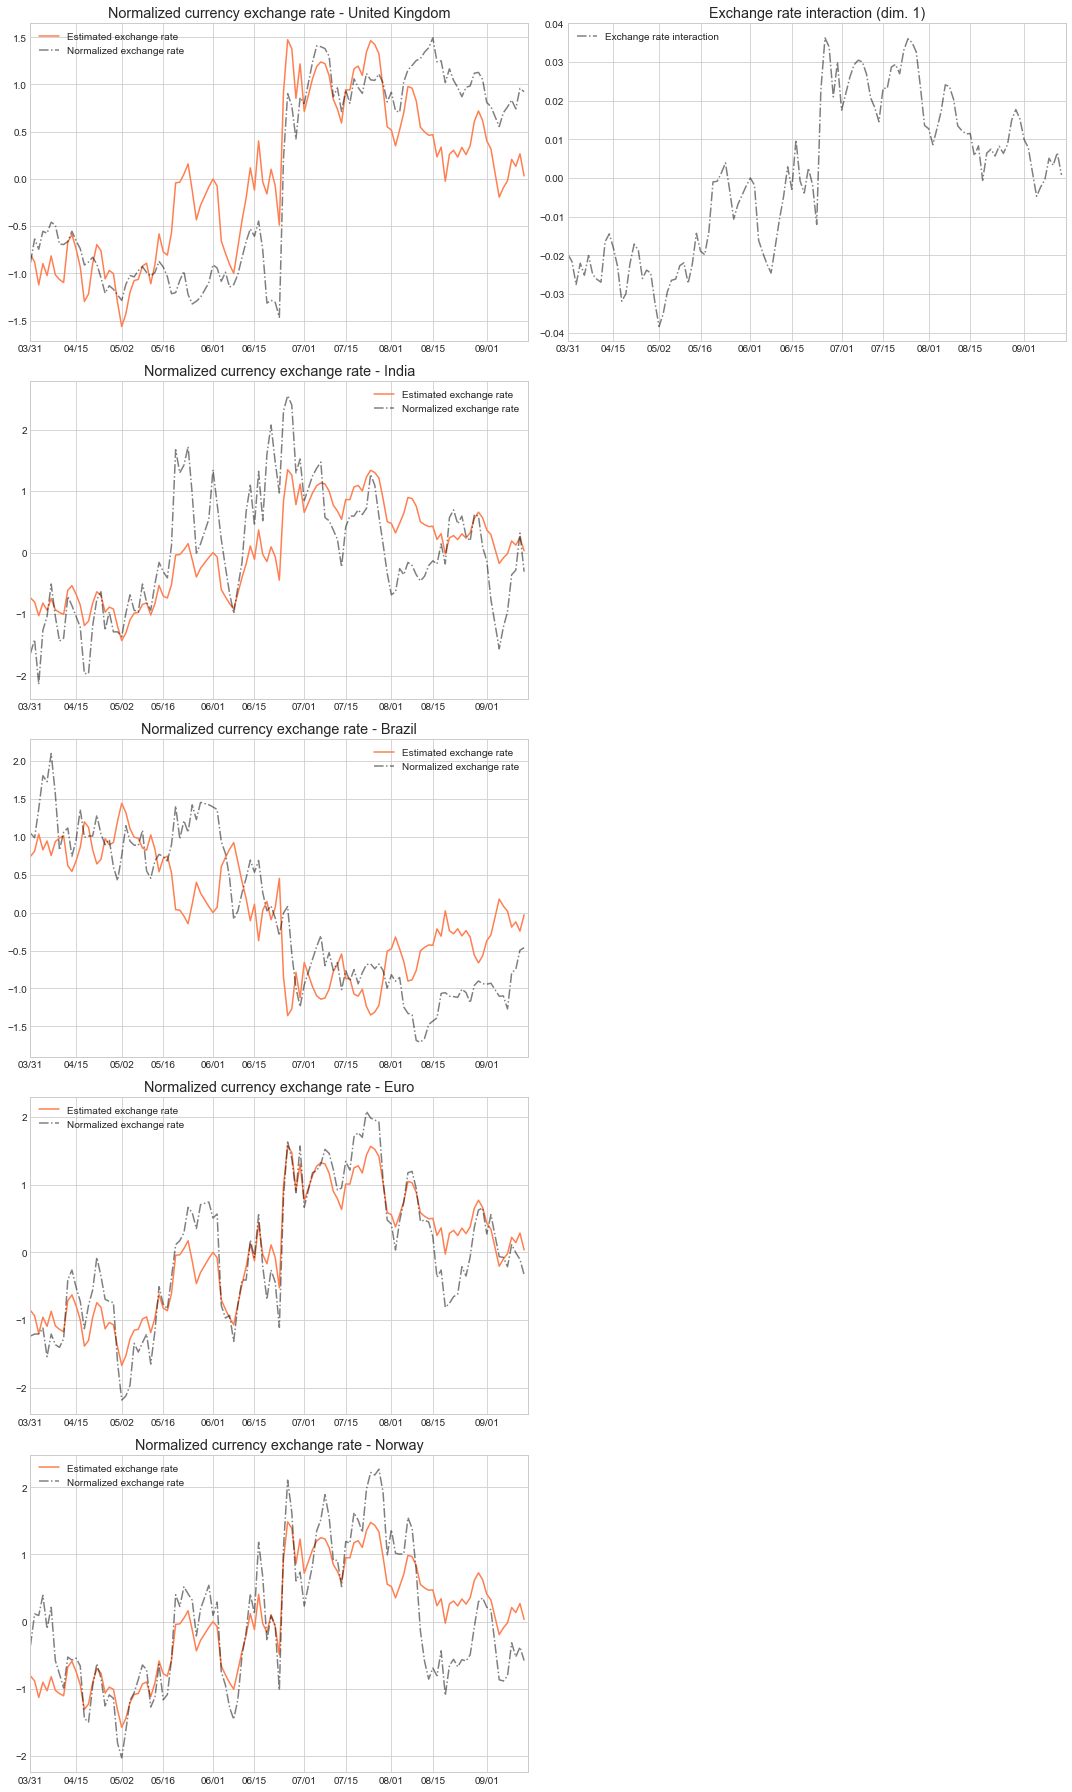

In [17]:
trump_election_day = '2016-06-23'
index_trump_election_day = np.where(valid_dates == trump_election_day)[0][0]
days_before, days_after = 60, 60
Y = country_rates.astype("f8")
print(index_trump_election_day - days_before, ":", index_trump_election_day + days_after, Y.shape, valid_dates.shape)
# Y = country_rates.astype("f8")
Y = Y[:, index_trump_election_day - days_before: index_trump_election_day + days_after]
Y_dates = valid_dates[index_trump_election_day - days_before: index_trump_election_day + days_after]
#Y = (Y.T - Y[:, 0]).T
Y = ((Y.T - Y.mean(axis=1)) / Y.std(axis=1)).T
#Y = Y[:, -30:]

lat_dim = 1
estimation_params = dict(
        min_iterations=3,
        max_iterations=50,

        min_improvement=0.01,
        sample_size=10000,
        population_size=120,
        penalty_low_variance_Q=0,#0.5,
        penalty_low_variance_R=0,#0.5,
        penalty_low_variance_P0=0,#0.5,
        penalty_low_std_mean_ratio=0,#0.5,
        penalty_inestable_system=0,#10.0,
        penalty_mse=1e15,#100,#1e-1,
        penalty_roughness_X=0,#0.5,
        penalty_roughness_Y=0,#0.5,
        max_length_loglikelihood=1000,
        return_details=True,
        random_spread=10,
)
method = "EM+PSO"
params1 = resdict_fromdata(ssm.estimate(
        method, "F H", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=None, H=None, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params1.show_performance(Y)
params2 = resdict_fromdata(ssm.estimate(
        method, "X0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params1.F, H=params1.H, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params2.show_performance(Y)
params3 = resdict_fromdata(ssm.estimate(
        method, "Q R P0", Y,
        Y.shape[0], 6, Y.shape[1],
        F=params2.F, H=params2.F, 
        Q=params2.Q, R=params2.R, 
        X0=None, P0=None,
        **estimation_params
))
print(); params3.show_performance(Y)
params4 = resdict_fromdata(ssm.estimate(
        method, "H F Q R X0 P0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params3.F, H=params3.F, 
        Q=params3.Q, R=params3.R, 
        X0=params3.X0, P0=params3.P0,
        **estimation_params
))
print(); params4.show_performance(Y)
plot_fitted_data(countries, params4.Xs, params4.Ys, Y, dates=ticks_from_first_week_day(Y_dates))

4498 : 4618 (5, 4935) (4935,)

* Log-likelihood: 0
* Low variance Q: 10
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0.01
* Inestable system: 2.6
* MSE: 0.36
* Roughness X: 0.77
* Roughness Y: 79

* Log-likelihood: 0
* Low variance Q: 1.9e+02
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0.01
* Inestable system: 2.6
* MSE: 0.36
* Roughness X: 0.77
* Roughness Y: 79

* Log-likelihood: 0
* Low variance Q: 38
* Low variance R: 0
* Low variance P0: 0
* Low std/mean ratio: 0
* Inestable system: 1.3e+02
* MSE: 0.42
* Roughness X: 3.7e+03
* Roughness Y: 1.6e+06

* Log-likelihood: 0
* Low variance Q: 78
* Low variance R: 1
* Low variance P0: 0
* Low std/mean ratio: 1
* Inestable system: 4.3
* MSE: 0.36
* Roughness X: 0.76
* Roughness Y: 69


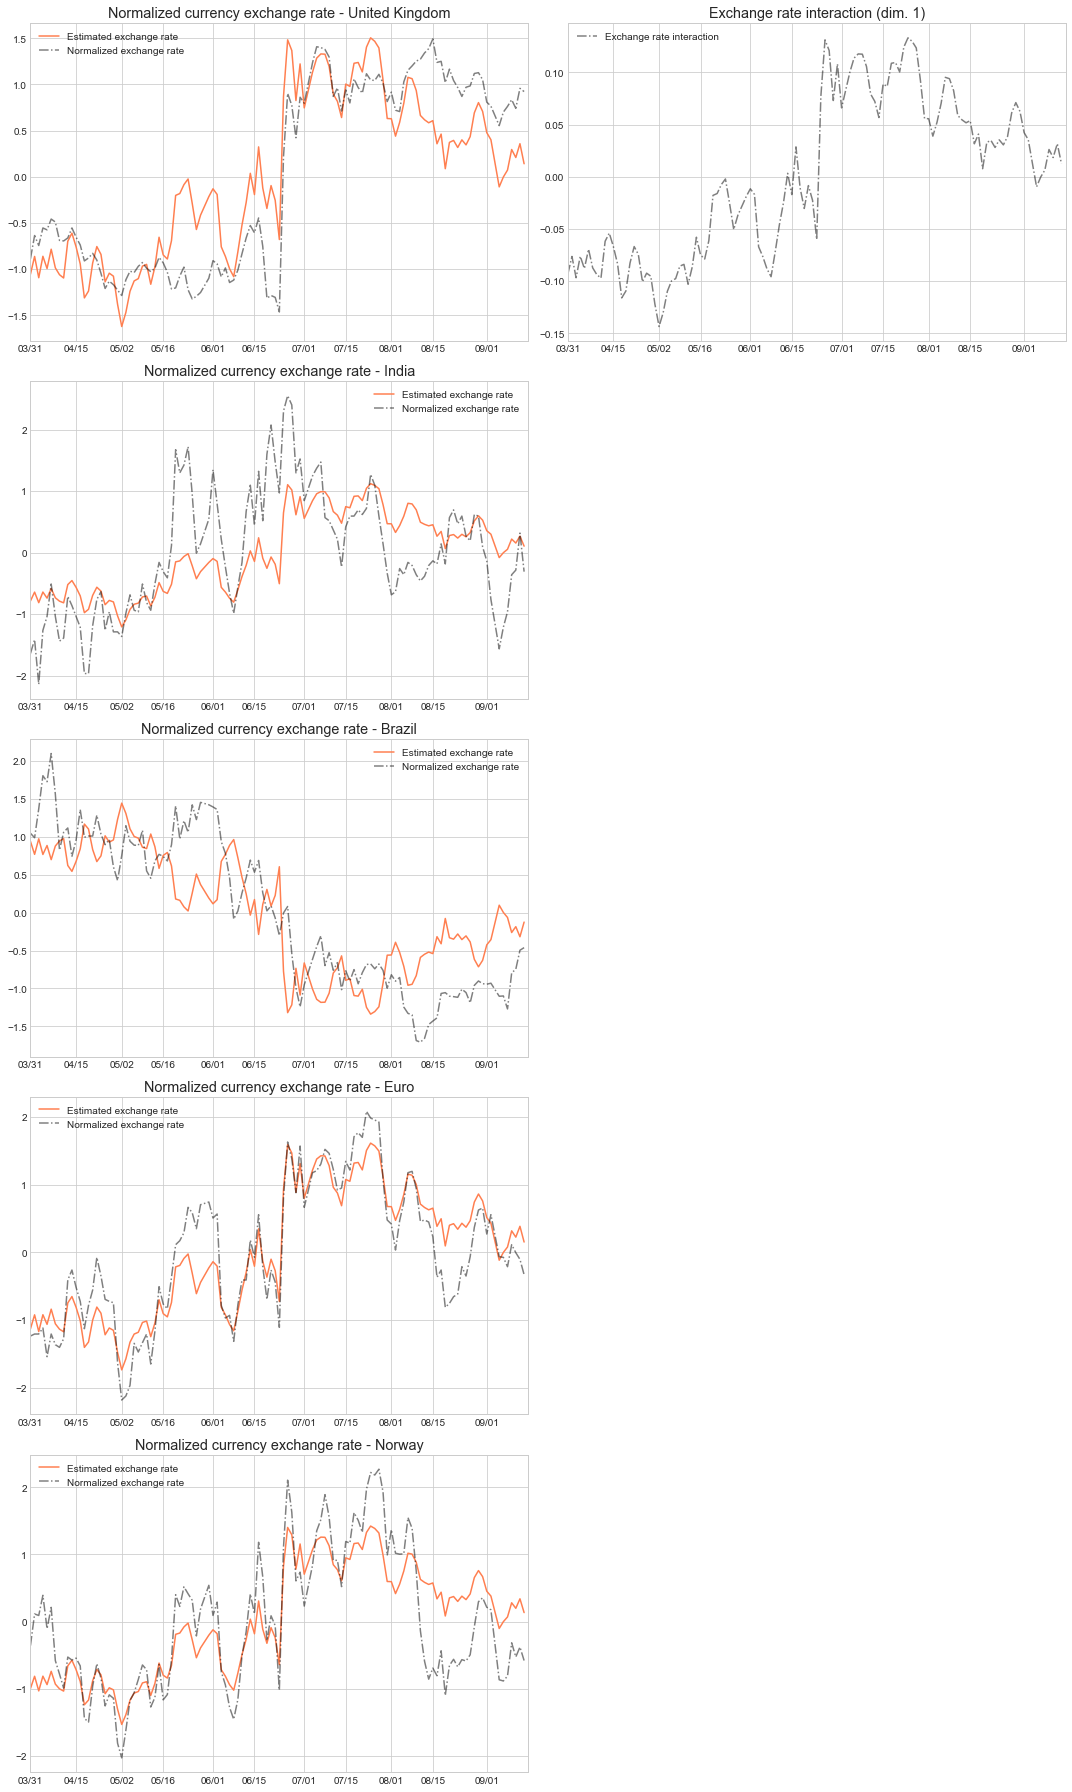

In [21]:
trump_election_day = '2016-06-23'
index_trump_election_day = np.where(valid_dates == trump_election_day)[0][0]
days_before, days_after = 60, 60
Y = country_rates.astype("f8")
print(index_trump_election_day - days_before, ":", index_trump_election_day + days_after, Y.shape, valid_dates.shape)
# Y = country_rates.astype("f8")
Y = Y[:, index_trump_election_day - days_before: index_trump_election_day + days_after]
Y_dates = valid_dates[index_trump_election_day - days_before: index_trump_election_day + days_after]
#Y = (Y.T - Y[:, 0]).T
Y = ((Y.T - Y.mean(axis=1)) / Y.std(axis=1)).T
#Y = Y[:, -30:]

lat_dim = 1
estimation_params = dict(
        min_iterations=3,
        max_iterations=50,

        min_improvement=0.01,
        sample_size=10000,
        population_size=130,
        penalty_low_variance_Q=0,#0.5,
        penalty_low_variance_R=0,#0.5,
        penalty_low_variance_P0=0,#0.5,
        penalty_low_std_mean_ratio=0,#0.5,
        penalty_inestable_system=0,#10.0,
        penalty_mse=1e15,#100,#1e-1,
        penalty_roughness_X=0,#0.5,
        penalty_roughness_Y=0,#0.5,
        max_length_loglikelihood=1000,
        return_details=True,
        random_spread=15,
)
method = "LSE+PSO"
params1 = resdict_fromdata(ssm.estimate(
        method, "F H", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=None, H=None, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params1.show_performance(Y)
params2 = resdict_fromdata(ssm.estimate(
        method, "X0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params1.F, H=params1.H, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params2.show_performance(Y)
params3 = resdict_fromdata(ssm.estimate(
        method, "Q R P0", Y,
        Y.shape[0], 6, Y.shape[1],
        F=params2.F, H=params2.F, 
        Q=params2.Q, R=params2.R, 
        X0=None, P0=None,
        **estimation_params
))
print(); params3.show_performance(Y)
params4 = resdict_fromdata(ssm.estimate(
        method, "H F Q R X0 P0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params3.F, H=params3.F, 
        Q=params3.Q, R=params3.R, 
        X0=params3.X0, P0=params3.P0,
        **estimation_params
))
print(); params4.show_performance(Y)
plot_fitted_data(countries, params4.Xs, params4.Ys, Y, dates=ticks_from_first_week_day(Y_dates))

4498 : 4618 (5, 4935) (4935,)

* Log-likelihood: 0
* Low variance Q: 7.5
* Low variance R: 0
* Low variance P0: 0
* Low std/mean ratio: 0
* Inestable system: 36
* MSE: 0.15
* Roughness X: 15
* Roughness Y: 2.8e+03

* Log-likelihood: 0
* Low variance Q: 7.9
* Low variance R: 0
* Low variance P0: 0
* Low std/mean ratio: 0
* Inestable system: 36
* MSE: 0.15
* Roughness X: 14
* Roughness Y: 2.8e+03

* Log-likelihood: 0
* Low variance Q: 6.2e+02
* Low variance R: 0
* Low variance P0: 0.04
* Low std/mean ratio: 0.01
* Inestable system: 1.6
* MSE: 0.6
* Roughness X: 1.4e+05
* Roughness Y: 6.4e+07

* Log-likelihood: 0
* Low variance Q: 41
* Low variance R: 0.66
* Low variance P0: 0.01
* Low std/mean ratio: 0.05
* Inestable system: 78
* MSE: 0.2
* Roughness X: 98
* Roughness Y: 1.9e+04


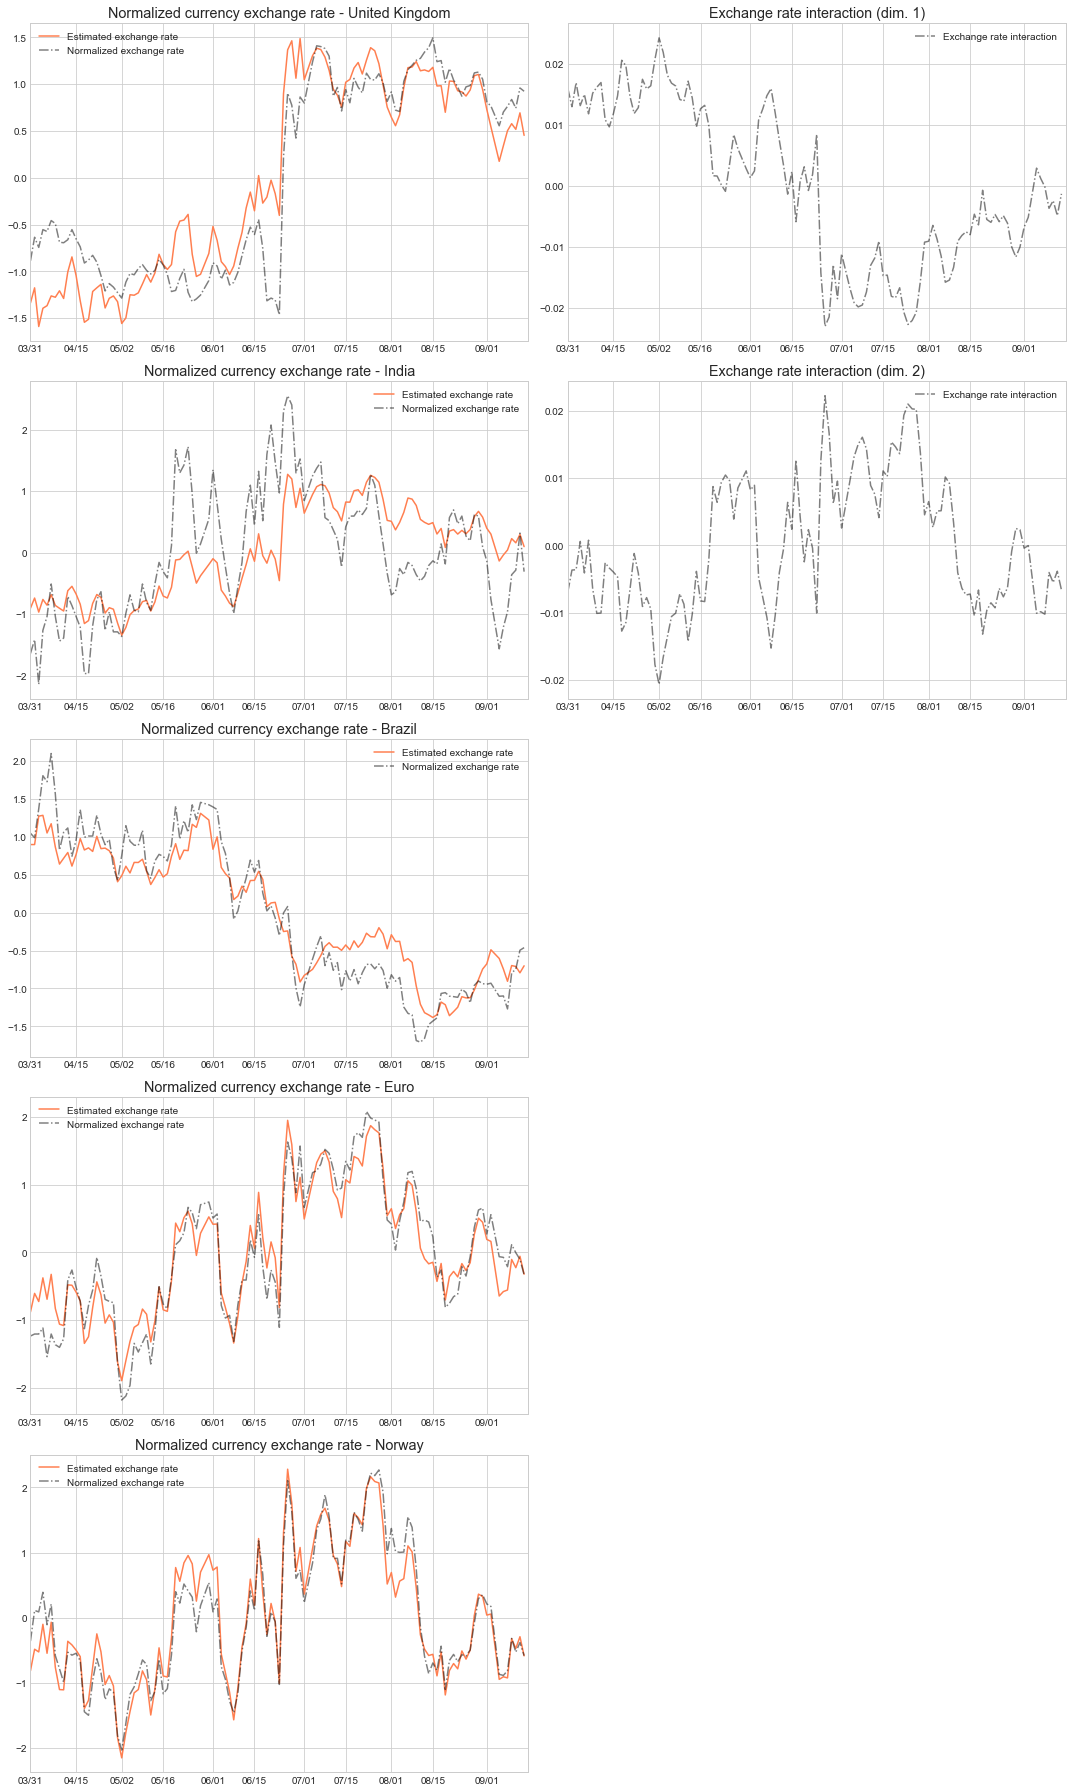

In [23]:
trump_election_day = '2016-06-23'#'2016-09-08'
index_trump_election_day = np.where(valid_dates == trump_election_day)[0][0]
days_before, days_after = 60, 60
Y = country_rates.astype("f8")
print(index_trump_election_day - days_before, ":", index_trump_election_day + days_after, Y.shape, valid_dates.shape)
# Y = country_rates.astype("f8")
Y = Y[:, index_trump_election_day - days_before: index_trump_election_day + days_after]
Y_dates = valid_dates[index_trump_election_day - days_before: index_trump_election_day + days_after]
#Y = (Y.T - Y[:, 0]).T
Y = ((Y.T - Y.mean(axis=1)) / Y.std(axis=1)).T
#Y = Y[:, -30:]

lat_dim = 2
estimation_params = dict(
        min_iterations=3,
        max_iterations=50,

        min_improvement=0.01,
        sample_size=10000,
        population_size=100,
        penalty_low_variance_Q=0,#0.5,
        penalty_low_variance_R=0,#0.5,
        penalty_low_variance_P0=0,#0.5,
        penalty_low_std_mean_ratio=0,#0.5,
        penalty_inestable_system=0,#10.0,
        penalty_mse=1e15,#100,#1e-1,
        penalty_roughness_X=0,#0.5,
        penalty_roughness_Y=0,#0.5,
        max_length_loglikelihood=1000,
        return_details=True,
        random_spread=10,
)
method = "PSO"
params1 = resdict_fromdata(ssm.estimate(
        method, "F H", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=None, H=None, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params1.show_performance(Y)
params2 = resdict_fromdata(ssm.estimate(
        method, "X0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params1.F, H=params1.H, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params2.show_performance(Y)
params3 = resdict_fromdata(ssm.estimate(
        method, "Q R P0", Y,
        Y.shape[0], 6, Y.shape[1],
        F=params2.F, H=params2.F, 
        Q=params2.Q, R=params2.R, 
        X0=None, P0=None,
        **estimation_params
))
print(); params3.show_performance(Y)
params4 = resdict_fromdata(ssm.estimate(
        method, "H F Q R X0 P0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params3.F, H=params3.F, 
        Q=params3.Q, R=params3.R, 
        X0=params3.X0, P0=params3.P0,
        **estimation_params
))
print(); params4.show_performance(Y)
plot_fitted_data(countries, params4.Xs, params4.Ys, Y, dates=ticks_from_first_week_day(Y_dates))

In [24]:
params4.H

array([[-104.15686335,  -46.96962363],
       [ -57.88168106,   -2.95164985],
       [  93.79626324,   86.74988584],
       [ -31.25358181,   55.25112585],
       [ -11.63668227,   90.59087344]])

In [25]:
import networkx as nx

In [26]:
countries

['United Kingdom', 'India', 'Brazil', 'Euro', 'Norway']

(-1.1519816848274618,
 1.2611792939972533,
 -1.2361062805125527,
 1.2361062975424504)

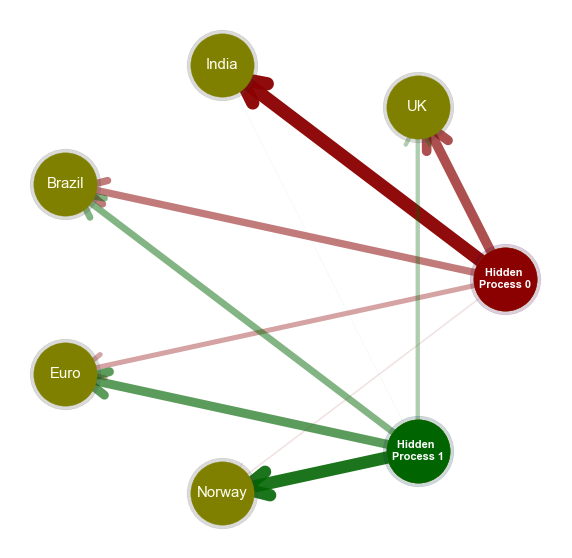

In [27]:
H1 = (params4.H.T / np.abs(params4.H).sum(axis=1)).T

G = nx.DiGraph()
#print(H1, "...", H1.shape[0], len(countries))
for c in range(H1.shape[1]):
    hidden = "Hidden \nProcess {0}".format(c)
    for r, country in enumerate(countries):
        country = "UK" if country == "United Kingdom" else country
        G.add_edge(hidden, country, weight=np.abs(H1[r, c]))


pos = nx.circular_layout(G)  # positions for all nodes

plt.figure(figsize=(10, 10))

colors = ["darkred", "darkgreen", "darkblue"]

nx.draw_networkx_nodes(G, pos, node_size=5000, node_color="darkblue", node_shape="o", alpha=0.1)

nodelistC = [k for k, v in pos.items() if not k.startswith("Hidden")]
labellistC = {k: k for k, v in pos.items() if not k.startswith("Hidden")}
#posH = {k: v for k, v in pos.items() if k.starswith("Hidden")}
nx.draw_networkx_nodes(G, pos, node_size=5000, node_color="olive", node_shape="o", alpha=0.1, nodelist=nodelistC)
nx.draw_networkx_nodes(G, pos, node_size=4000, node_color="olive", node_shape="o", alpha=1)
nx.draw_networkx_labels(G, pos, font_size=15, font_family='sans-serif', font_color="ivory", labels=labellistC)
for c in range(H1.shape[1]):
    hidden = "Hidden \nProcess {0}".format(c)
    nodelistC = [k for k, v in pos.items() if k == hidden]
    labellistC = {k: k for k, v in pos.items() if k == hidden}
    nx.draw_networkx_nodes(G, pos, node_size=5000, node_color=colors[c], node_shape="o", alpha=0.1, nodelist=nodelistC)
    nx.draw_networkx_nodes(G, pos, node_size=4000, node_color=colors[c], node_shape="o", alpha=1, nodelist=nodelistC)
    nx.draw_networkx_labels(G, pos, font_size=11, font_family='sans-serif', font_color="white", font_weight="bold", labels=labellistC)

#
for c in range(H1.shape[1]):
    hidden = "Hidden \nProcess {0}".format(c)
    #edges_hp = [(u, v) for (u, v, d) in G.edges(data=True) if u == hidden]
    for (u, v, d) in G.edges(data=True):
        if u != hidden and v != hidden: continue
        arrowstyle = "simple"
        arrowstyle = "wedge"
        arrowstyle = "->"
        width = 20
        """
        nx.draw_networkx_edges(G, pos,
                               edgelist=[(u, v)],
                               width=width * d["weight"],
                               arrowstyle=arrowstyle,
                               #arrowsize=100,
                               arrows=True,
                               #alpha=0.5,
                               alpha=d["weight"],
                               edge_color=colors[c])#, style='dashed')
        """
        nx.draw_networkx_edges(G, pos,
                               edgelist=[(u, v)],
                               width=0.7 * width * d["weight"],
                               arrowstyle=arrowstyle,
                               arrowsize=60,
                               arrows=True,
                               #alpha=0.85,
                               alpha=d["weight"],
                               edge_color=colors[c])#, style='dashed')
plt.xticks([])
plt.yticks([])
#fig.patch.set_visible(False)
plt.gca().axis('off')
#nx.draw_networkx_edges(G, pos,width=6)

In [28]:
print("\n".join("{0}: {1}".format(k, getattr(params4, k)) for k in ["F", "H", "Q", "R", "X0", "P0"]))

F: [[6.57645291 2.74585096]
 [5.69964644 1.83736461]]
H: [[-104.15686335  -46.96962363]
 [ -57.88168106   -2.95164985]
 [  93.79626324   86.74988584]
 [ -31.25358181   55.25112585]
 [ -11.63668227   90.59087344]]
Q: [[10.          6.51127548]
 [ 6.51127548  7.97087178]]
R: [[10.         -0.2345188   1.08431096  3.85058658 -2.41420672]
 [-0.2345188   7.86150781 -0.56207593 -1.45689308  1.88231341]
 [ 1.08431096 -0.56207593 10.          1.24277187 -2.39638753]
 [ 3.85058658 -1.45689308  1.24277187 10.         -2.41940885]
 [-2.41420672  1.88231341 -2.39638753 -2.41940885  9.95013955]]
X0: [[ -7.1311398 ]
 [-11.02983292]]
P0: [[ 8.17893963 -4.09742344]
 [-4.09742344  9.83509379]]


![WorldResults.png](WorldResults.png)

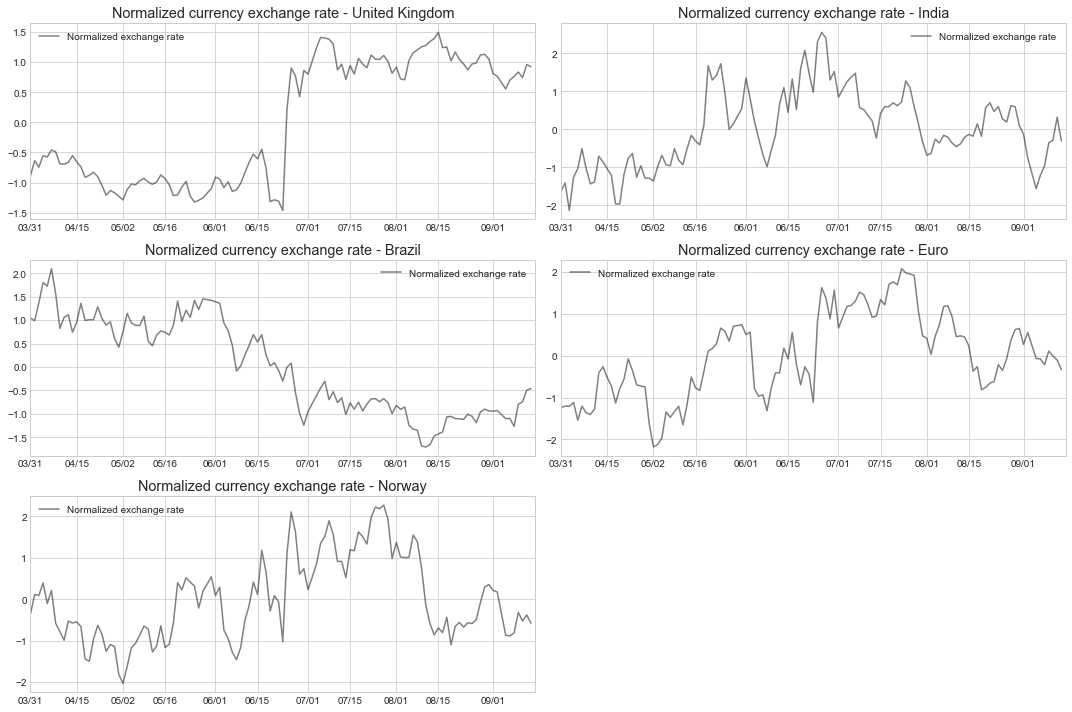

In [29]:
plt.figure(figsize=(15, 10))
#plot_fitted_data(countries, params4.Xf, params4.Yf, Y, dates=ticks_from_first_week_day(Y_dates))
for k in range(Y.shape[0]):
    plt.subplot(np.round(Y.shape[0]/2 + 1e-1), 2, k + 1)
    plt.plot(Y[k, :].ravel(), linestyle="-", color="black", alpha=0.5, label="Normalized exchange rate")
    plt.title("Normalized currency exchange rate - {0}".format(countries[k]))
    plt.xlim(0, Y.shape[1])
    plt.xticks(*ticks_from_first_week_day(Y_dates))
    plt.legend()
plt.tight_layout()
plt.savefig("InputDataPlots.png", dpi=90)

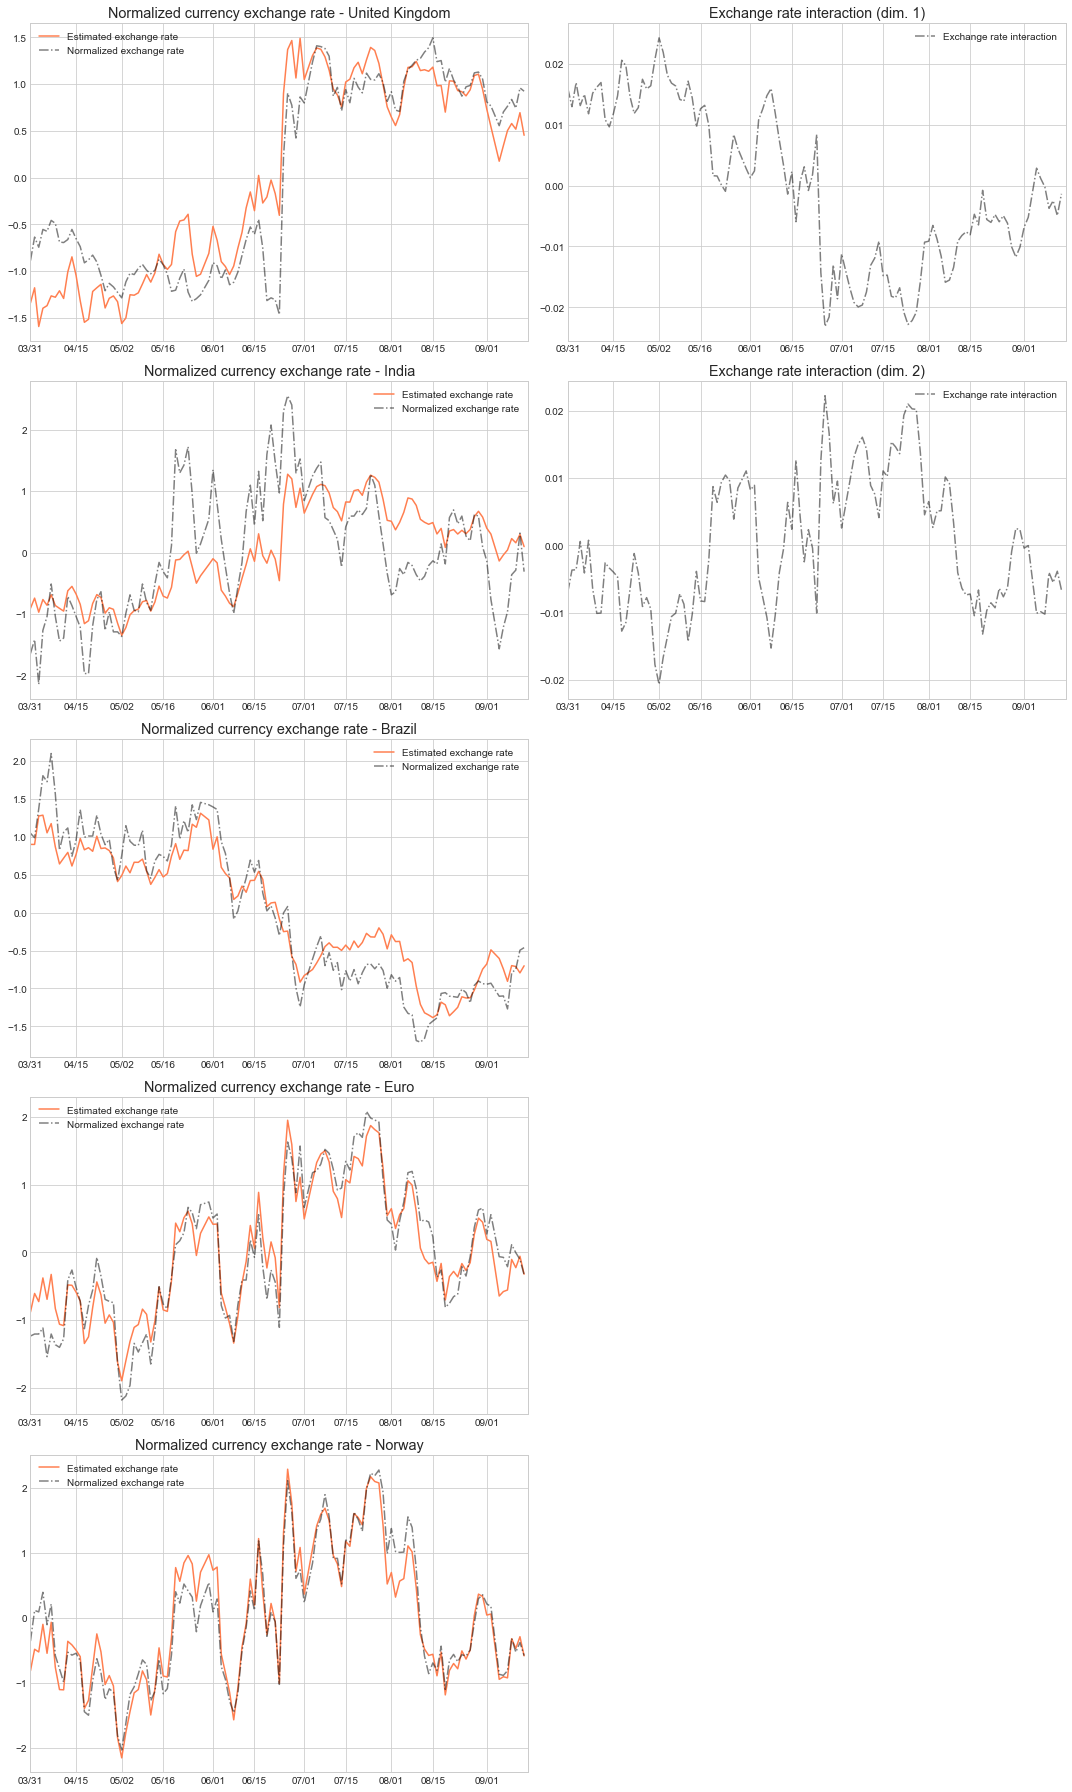

In [30]:
plot_fitted_data(countries, params4.Xf, params4.Yf, Y, dates=ticks_from_first_week_day(Y_dates))
plt.savefig("EstimatedDataPlots.png", dpi=90)

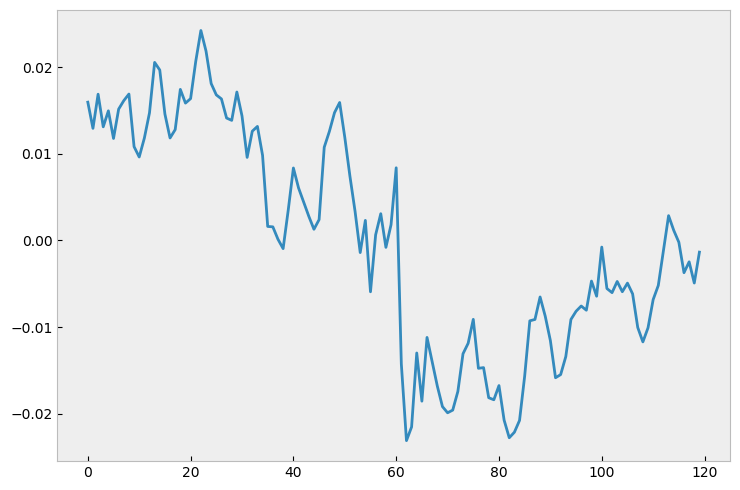

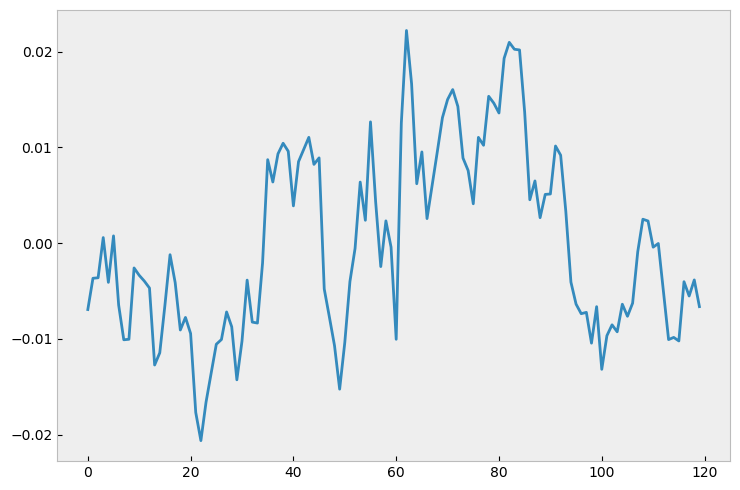

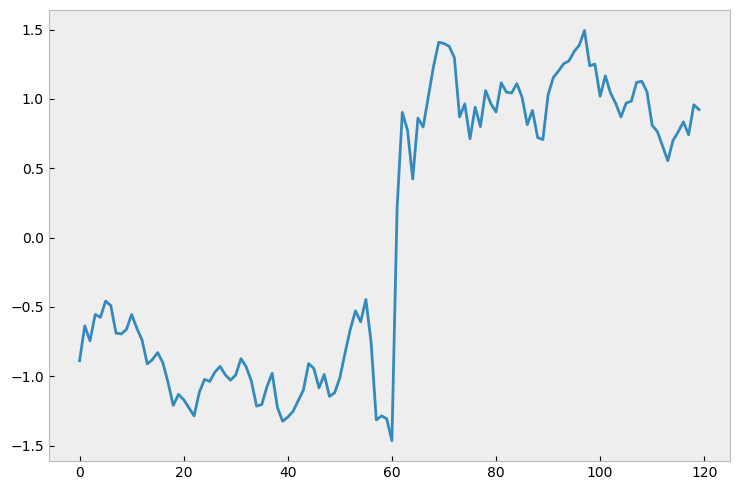

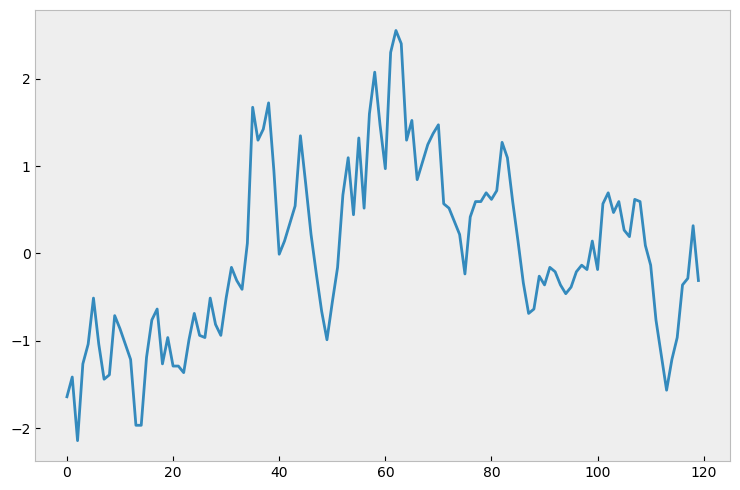

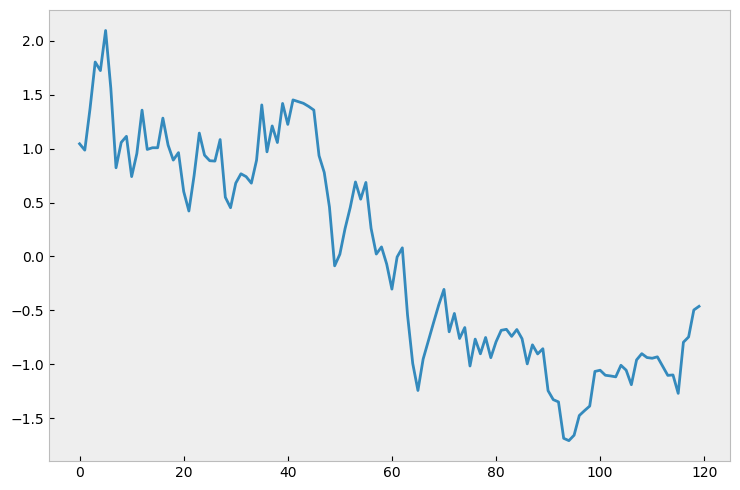

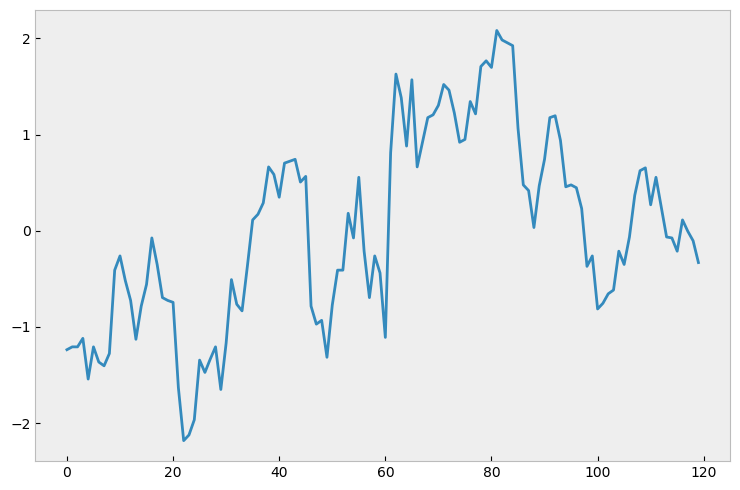

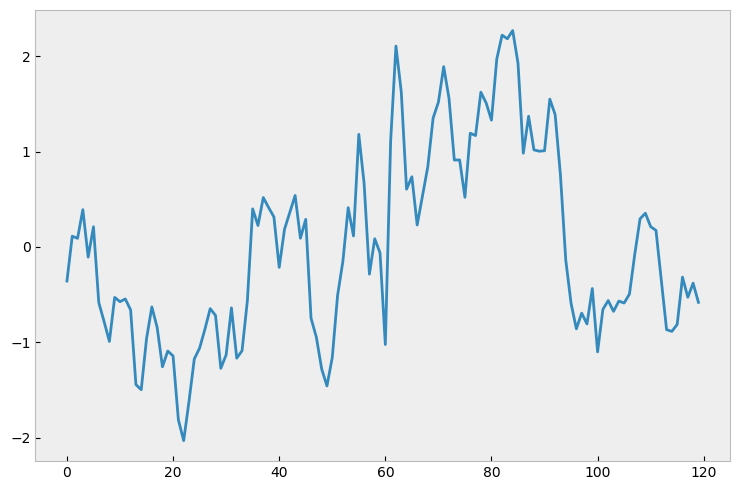

In [31]:
plt.style.use("Solarize_Light2")
plt.style.use("default")
plt.style.use("bmh")
for k in range(params4.Xs.shape[0]):
    plt.figure(figsize=(7.5, 5))
    plt.grid(False)
    plt.plot(params4.Xs[k, :].ravel())
    plt.tight_layout()
    plt.savefig("Results-Hidden{0}.png".format(k), dpi=75)
    plt.plot()
for k in range(Y.shape[0]):
    plt.figure(figsize=(7.5, 5))
    #plt.axis('off')
    plt.grid(False)
    plt.plot(Y[k, :].ravel())
    plt.tight_layout()
    plt.savefig("Results-Obs{0}.png".format(k), dpi=75)
    plt.plot()


* Log-likelihood: 0
* Low variance Q: 0.01
* Low variance R: 0
* Low variance P0: 0
* Low std/mean ratio: 0
* Inestable system: 0.31
* MSE: 0.14
* Roughness X: 11
* Roughness Y: 2.2e+03
F: [[-0.41894247 -0.0144889 ]
 [ 3.58172896  0.49042021]]
H: [[ 34.26767871  10.49096945]
 [-29.18725896  23.76800018]
 [-42.61547867  -6.74912877]
 [  8.95807211  17.63983035]
 [-12.94846334  23.52278257]]
Q: [[0.001 0.   ]
 [0.    0.001]]
R: [[0.001 0.    0.    0.    0.   ]
 [0.    0.001 0.    0.    0.   ]
 [0.    0.    0.001 0.    0.   ]
 [0.    0.    0.    0.001 0.   ]
 [0.    0.    0.    0.    0.001]]
X0: [[ -4.37715934]
 [-19.2957138 ]]
P0: [[0.001 0.   ]
 [0.    0.001]]


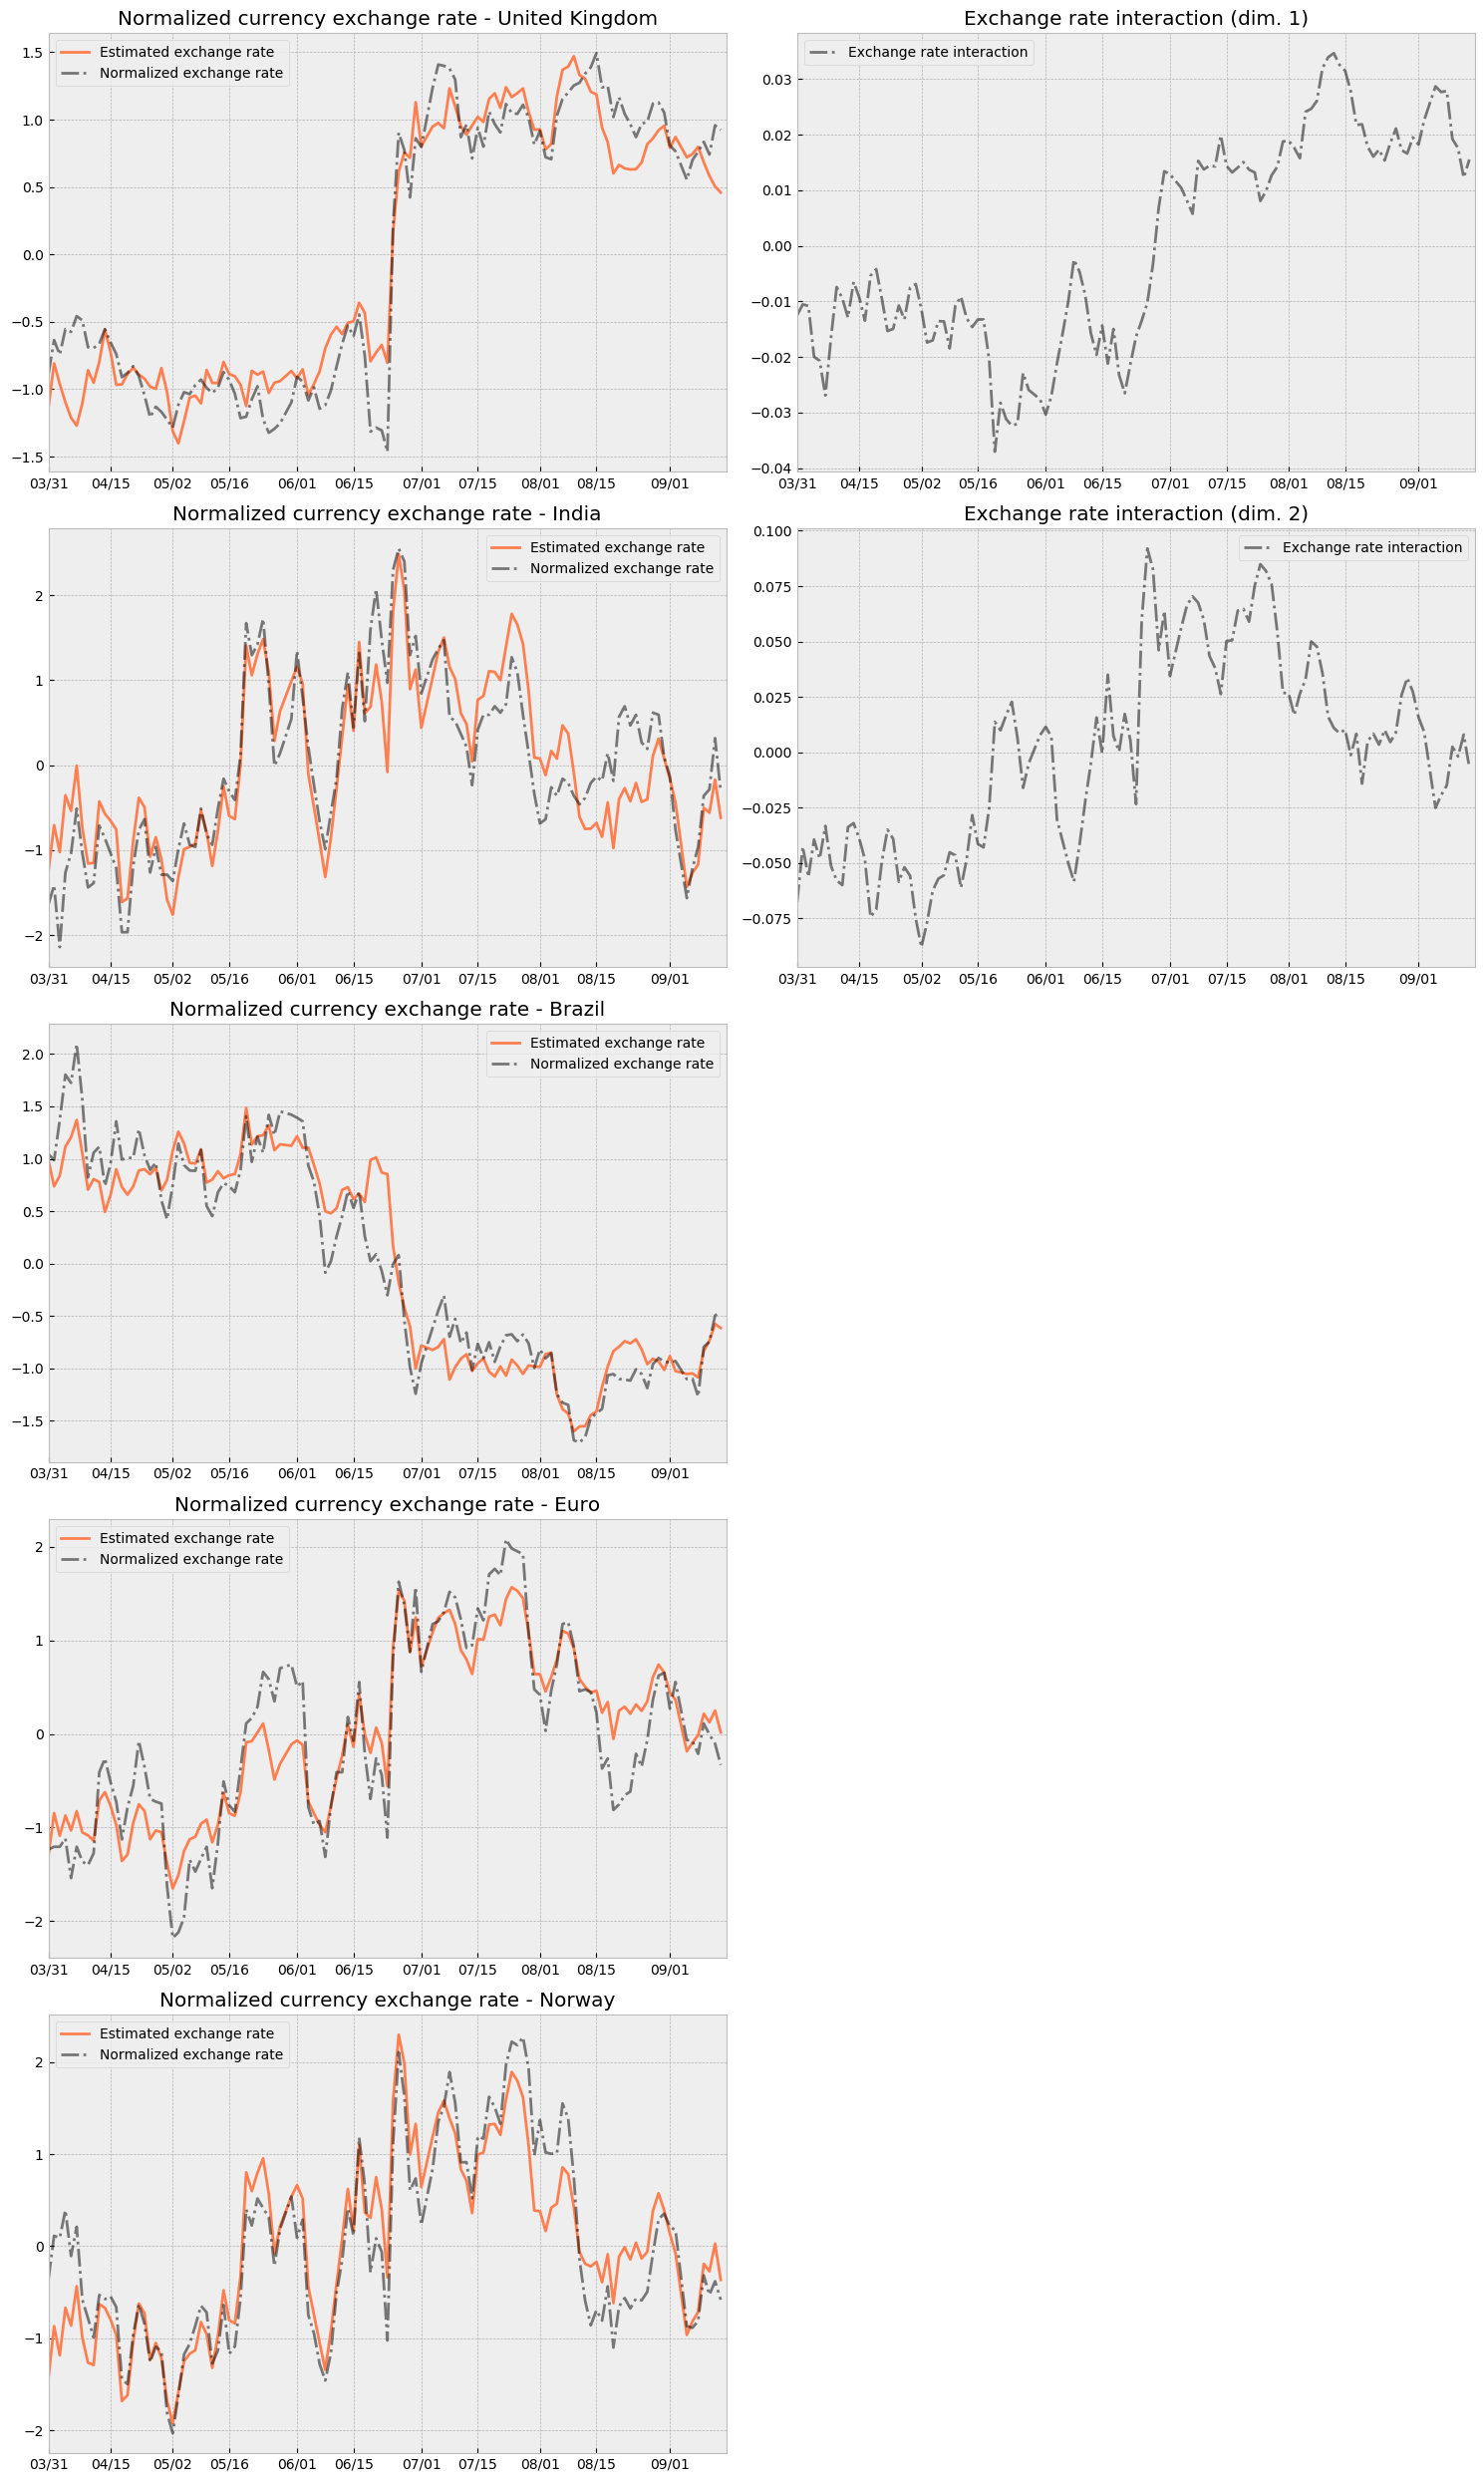

In [32]:
lat_dim=2
params5 = resdict_fromdata(ssm.estimate(
        #"PSO", "H F X0 Q R P0", Y,
        "EM+PSO", "H F X0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        Q=1e-3 * np.eye(*params1.Q.shape),
        R=1e-3 * np.eye(*params1.R.shape),
        P0=1e-3 * np.eye(*params1.P0.shape),
        min_iterations=10,
        max_iterations=50,

        min_improvement=0.01,
        sample_size=10000,
        population_size=100,
        penalty_low_variance_Q=0,#0.5,
        penalty_low_variance_R=0,#0.5,
        penalty_low_variance_P0=0,#0.5,
        penalty_low_std_mean_ratio=0,#0.5,
        penalty_inestable_system=2e5,#10.0,
        penalty_mse=1e9,#100,#1e-1,
        penalty_roughness_X=0,#0.5,
        penalty_roughness_Y=0,#0.5,
        max_length_loglikelihood=1000,
        return_details=True,
        random_spread=10,
))
print(); params5.show_performance(Y)
print("\n".join("{0}: {1}".format(k, getattr(params5, k)) for k in ["F", "H", "Q", "R", "X0", "P0"]))
plot_fitted_data(countries, params5.Xf, params5.Yf, Y, dates=ticks_from_first_week_day(Y_dates))
#plt.savefig("EstimatedDataPlots.png", dpi=90)

In [33]:
sys.path.extend([os.getcwd() + "/../../tests/python/module"])
import benchmark_performance as bp

In [44]:
params5.show_performance(Y)
np.sum(np.linalg.eig(params5.F)[0] ** 2), params5.H, params5.F, params5.Q, params5.R

* Log-likelihood: 0
* Low variance Q: 0.01
* Low variance R: 0
* Low variance P0: 0
* Low std/mean ratio: 0
* Inestable system: 0.31
* MSE: 0.14
* Roughness X: 11
* Roughness Y: 2.2e+03


(0.31223413825773905, array([[ 34.26767871,  10.49096945],
        [-29.18725896,  23.76800018],
        [-42.61547867,  -6.74912877],
        [  8.95807211,  17.63983035],
        [-12.94846334,  23.52278257]]), array([[-0.41894247, -0.0144889 ],
        [ 3.58172896,  0.49042021]]), array([[0.001, 0.   ],
        [0.   , 0.001]]), array([[0.001, 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.001, 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.001, 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.001, 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.001]]))

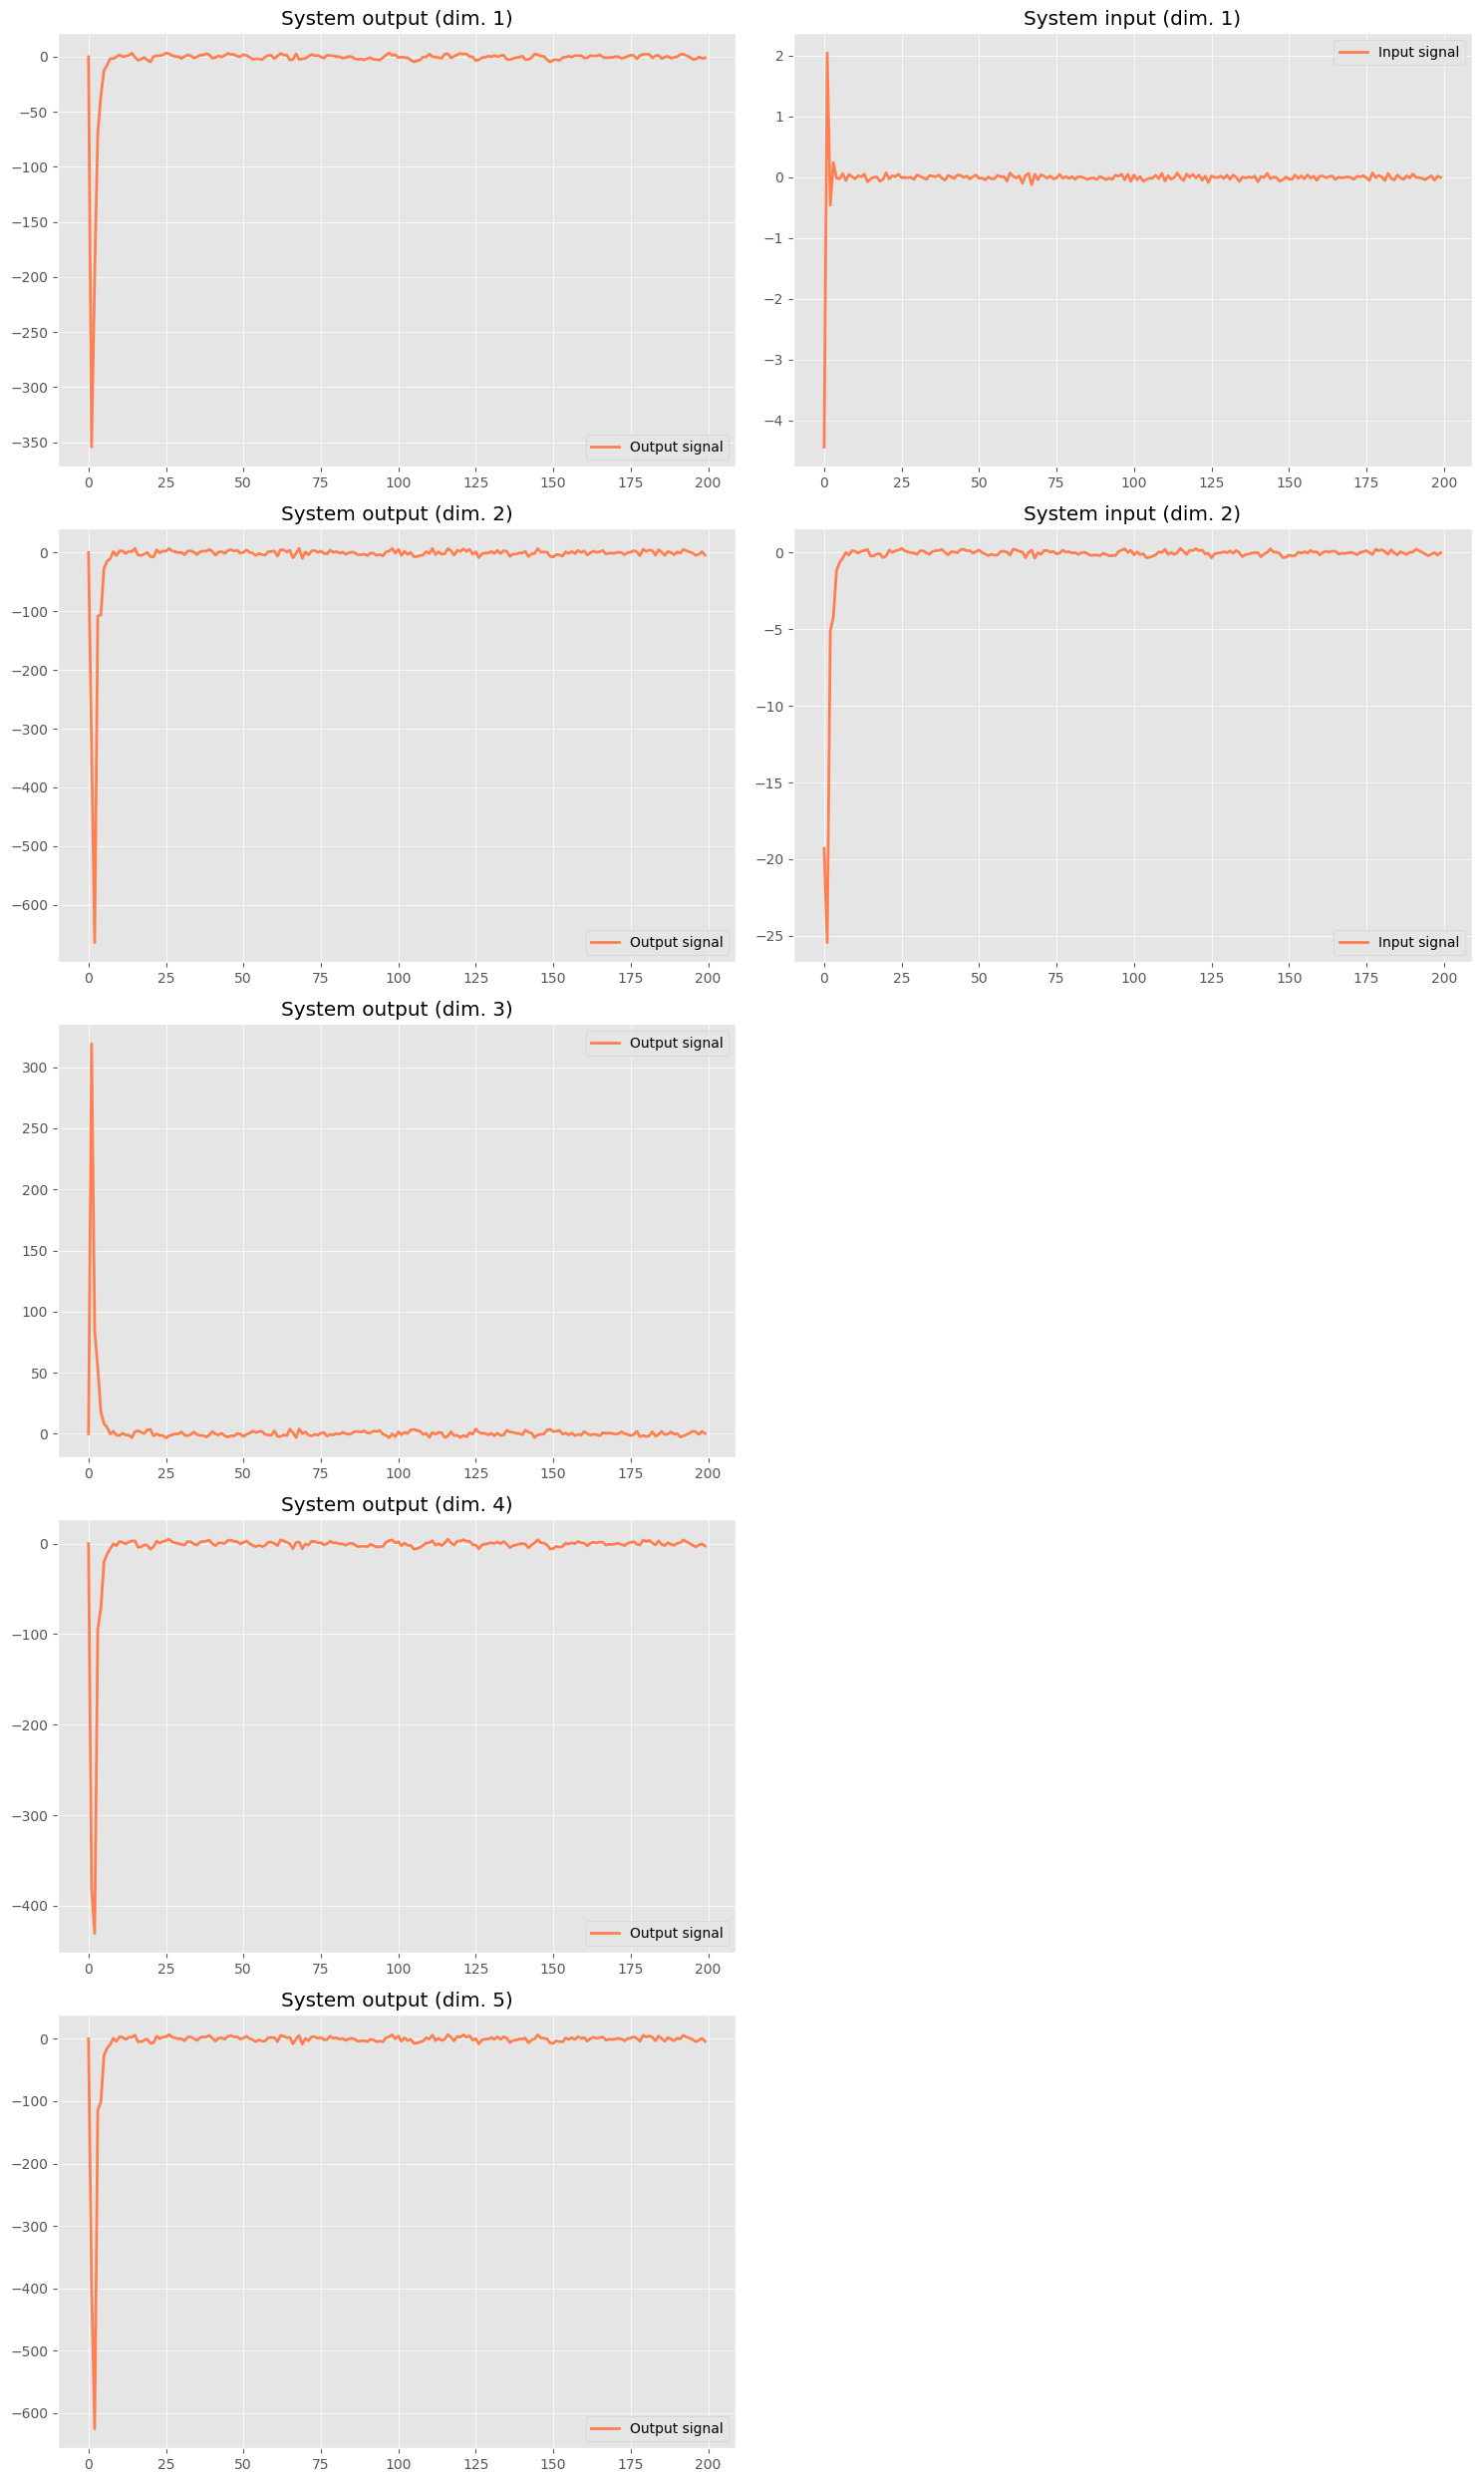

In [50]:
params6 = params5.copy()
#params6.X0 = params5.Xs[:, 0]
#params6.P0 = 0.01 * np.eye(*params6.P0.shape)
#params6.R = 0.01 * np.eye(*params6.R.shape)
#params6.Q = 0.01 * np.eye(*params6.Q.shape)
Xsim1, Ysim1 = bp.simulateParams(200, params6)
plot_utils.plot_system_signals(Xsim1, Ysim1)

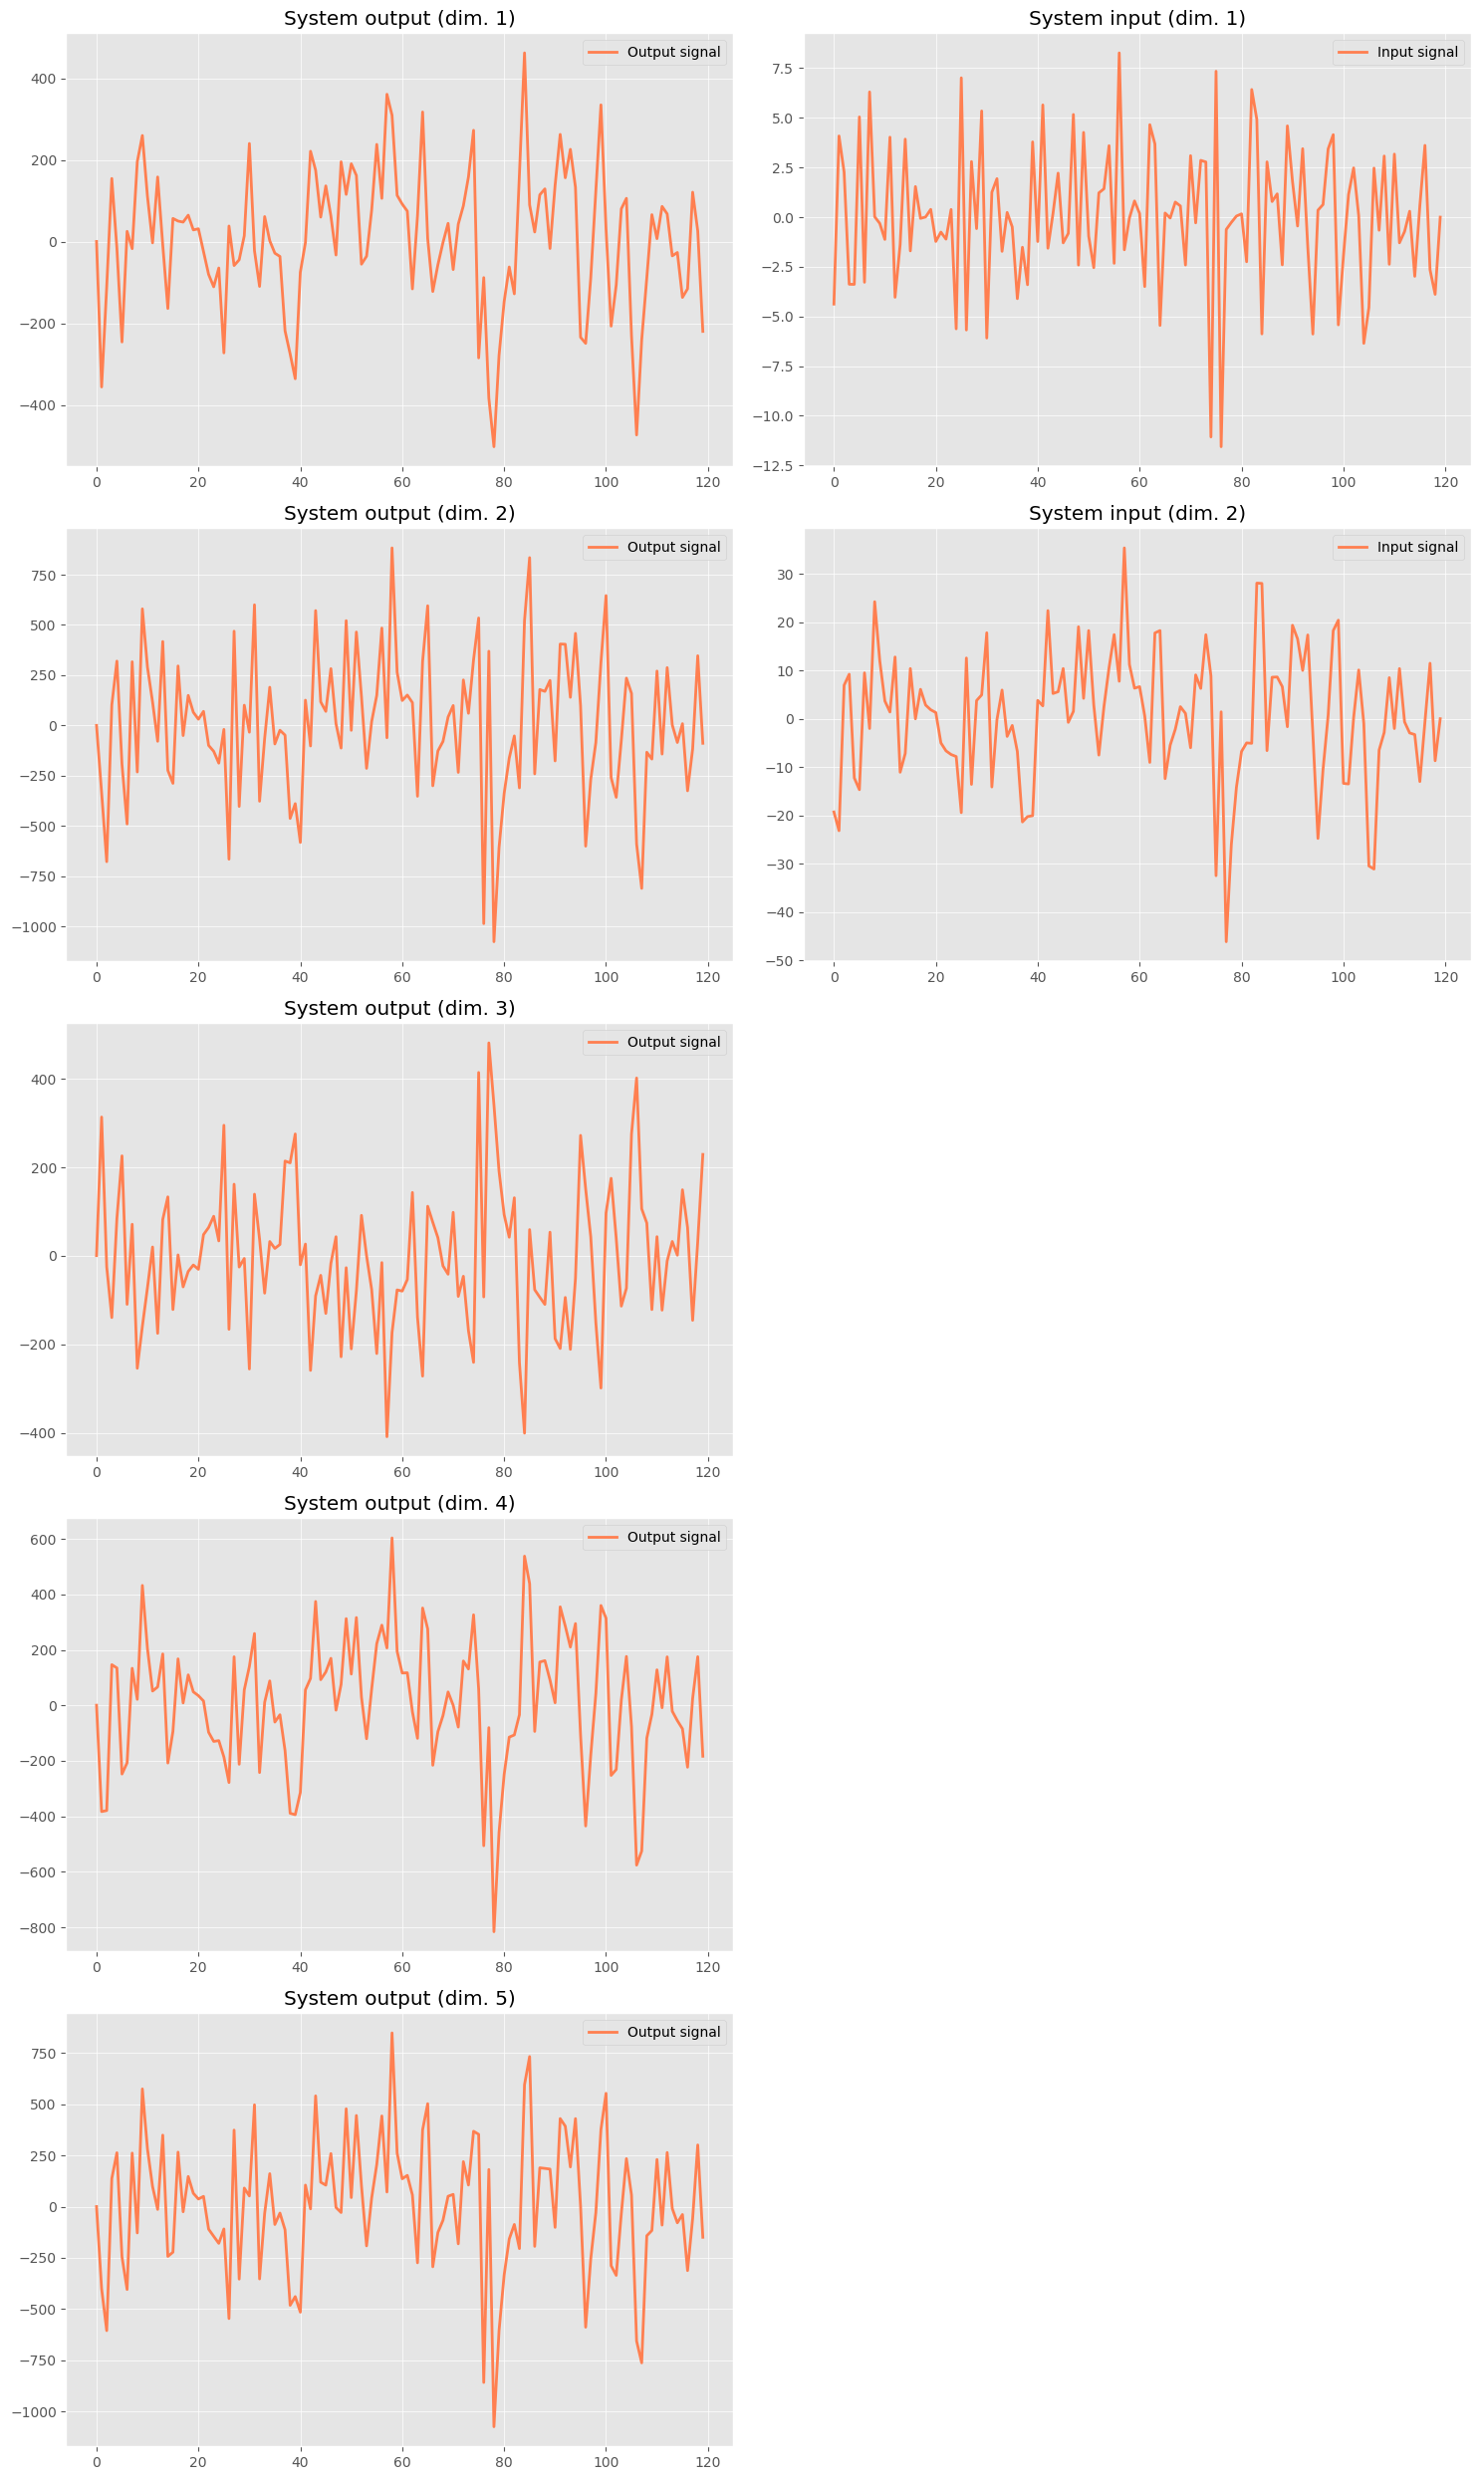

In [56]:
ALL_PARAMETERS = "F H Q R X0 P0"

def simVAR(n, A, X0, P0):
    Xs = np.zeros((X0.shape[0], n), dtype="f8")
    Xs[:, 0] = X0.ravel()
    for t in range(1, n - 1):
        Xs[:, t] = A.dot(Xs[:, t - 1]) + 100* np.random.multivariate_normal(np.zeros(P0.shape[0]), P0)[0]
    return Xs

def simObs(H, Xs, R):
    n = Xs.shape[1]
    Ys = np.zeros((H.shape[0], n), dtype="f8")
    for t in range(n):
        Ys[:, t] = H.dot(Xs[:, t - 1]) +100* np.random.multivariate_normal(np.zeros(R.shape[0]), R)[0]
    return Ys

def simSSM(n, F, H, X0, P0, Q, R):
    X0e = X0#np.random.multivariate_normal(X0.ravel(), P0).reshape(X0.shape)
    Xs = simVAR(n, F, X0e, Q)
    Ys = simObs(H, Xs, R)
    return Xs, Ys

def simulateParams(n, params):
    return simSSM(n, params.F, params.H, params.X0, params.P0, params.Q, params.R)

Xsim1, Ysim1 = simulateParams(120, params6)
plot_utils.plot_system_signals(Xsim1, Ysim1)

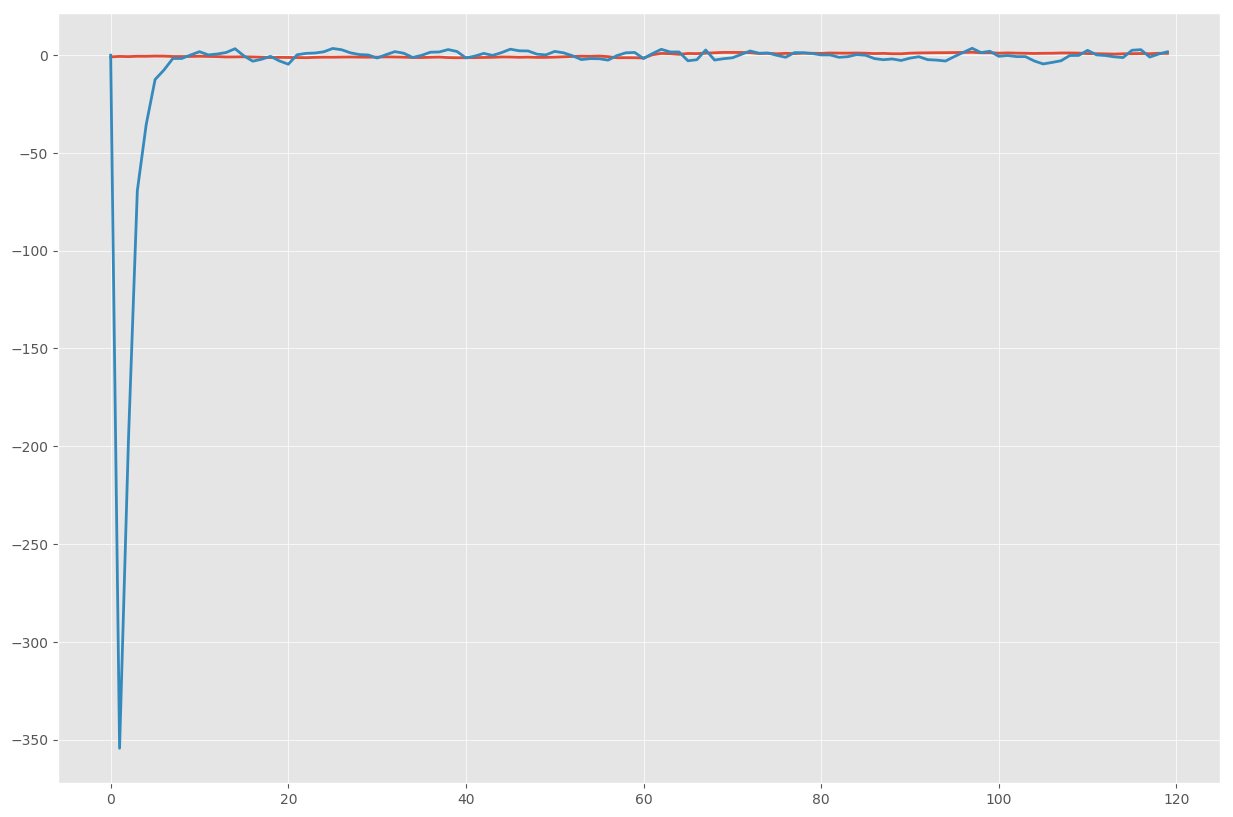

In [51]:
plt.plot(Y[0, :].ravel())
plt.plot(Ysim1[0, : Y.shape[1]])

In [ ]:
1+3